# <u>Geometric image classification substructure of the Hornsund Fjord: Time Series Analysis </u>  <br /> <sub> <span style="font-size:smaller;"> Jullian C.B. Williams </span> </sub> <br /> <sub> <span style="font-size:smaller;"> *Polish Academy of Sciences, Institute of Geophysics, Warsaw, Poland* </span> </sub>


In [113]:
import emoji #<---- Death and taxes are for certain. Try to have fun before you're 6 feet too far under to.
from rich.console import Console #<---- Ditto.

import fiona
import random
import warnings
import argparse, os
import pyarrow as pa
from datetime import datetime
from shapely.geometry import box
from shapely.geometry import shape
from shapely.geometry import Polygon
from shapely.affinity import translate

import numpy as np
import pandas as pd
from osgeo import ogr
from osgeo import gdal #<---- to geospatial env.
import geopandas as gpd

from PIL import Image

import seaborn as sns
import rasterio as rio
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.plot import show_hist 
from rasterstats import zonal_stats
from rasterio.features import shapes
from rasterio.plot import adjust_band
from rasterio.features import rasterize

import seaborn as sns
import matplotlib.image
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib import patches as mpatches
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

from spectral import *
from sklearn import svm
from scipy import stats
from scipy import ndimage
from scipy import fftpack
from sklearn.svm import SVC
from scipy.fft import fft, ifft
from scipy.ndimage import zoom
from scipy.ndimage import sobel
from scipy.stats import entropy
import spectral.io.envi as envi #run PCA
from sklearn.svm import LinearSVC
from skimage import io, transform # from scipy.misc import imresize  <---- here...we...go..
from scipy.stats import normaltest
from skimage.morphology import disk #manage disk while running.
from skimage.segmentation import slic
from sklearn.decomposition import PCA
from skimage.util import img_as_ubyte #Avoid precision loss converting image of type float32 to uint8 as required by rank filters.
from skimage.filters.rank import entropy #for GLCM entropy.
from sklearn.pipeline import make_pipeline
from skimage.segmentation import chan_vese
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.gofplots import qqplot
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from skimage.feature import graycomatrix, graycoprops # from skimage.feature import greycomatrix, greycoprops <--- depreciated or..? lang.
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

# SVM

## Winter

In [197]:
input_dir = "C:/Users/jullian.williams/Desktop/RS_Winter/"

dataframesrs = []

# Loop through all .tif files in the input directory
for subdir, _, files in os.walk(input_dir):
    for filename in files: 
        # Check if the file is an image (e.g., .jpg, .png)
        if filename.endswith(('.tif')):
            input_path = os.path.join(subdir, filename)
             
            with rio.open(input_path) as src_:
                profile = src_.profile  # Save metadata
                transform_ = src_.transform
                crs_=src_.crs
                b1_ = src_.read(1)
                
                def image_to_geodataframe(image_array, transform, crs):
            # Generate shapes (polygons) from the raster array
                    shapes_generator = shapes(image_array, transform=transform_)
                    
                    # Create a GeoDataFrame
                    geometries = []
                    values = []
                    for geom, value in shapes_generator:
                        geometries.append(shape(geom))
                        values.append(value)

                        name, ext = os.path.splitext(filename)
                        raftposition = 17
                        bfposition = 9
                
                        # Create the new file name
                        file_name = f"{filename[:raftposition]}"
                        fname = f"{file_name[bfposition:]}"
                                
                            
                    gdf = gpd.GeoDataFrame({'value': values, 'geometry': geometries, 'date':fname}, crs=crs_)
                    
                    return gdf 
                    
            gdf = image_to_geodataframe(b1_, transform=transform_, crs=crs_)


            gdf['date'] = pd.to_datetime(gdf['date'])
            gdf['area'] = gdf.geometry.area
            gdf['perimeter'] = gdf.geometry.length
            gdf['centroid'] = gdf.geometry.centroid
            # Extract latitude and longitude from centroids
            gdf['longitude'] = gdf.centroid.x
            gdf['latitude'] = gdf.centroid.y
            gdf.set_crs(epsg=32633, inplace=True)

            dataframesrs.append(gdf)

In [198]:
input_dir = "C:/Users/jullian.williams/Desktop/EW_Winter/"

dataframesew = []

# Loop through all .tif files in the input directory
for subdir, _, files in os.walk(input_dir):
    for filename in files: 
        # Check if the file is an image (e.g., .jpg, .png)
        if filename.endswith(('.tif')):
            input_path = os.path.join(subdir, filename)
             
            with rio.open(input_path) as src_:
                profile = src_.profile  # Save metadata
                transform_ = src_.transform
                crs_=src_.crs
                b1_ = src_.read(1)
                
                def image_to_geodataframe(image_array, transform, crs):
            # Generate shapes (polygons) from the raster array
                    shapes_generator = shapes(image_array, transform=transform_)
                    
                    # Create a GeoDataFrame
                    geometries = []
                    values = []
                    for geom, value in shapes_generator:
                        geometries.append(shape(geom))
                        values.append(value)

                        name, ext = os.path.splitext(filename)
                        raftposition = 15
                        bfposition = 7
                
                        # Create the new file name
                        file_name = f"{filename[:raftposition]}"
                        fname = f"{file_name[bfposition:]}"
                                
                            
                    gdf = gpd.GeoDataFrame({'value': values, 'geometry': geometries, 'date':fname}, crs=crs_)
                    
                    return gdf 
                    
            gdf = image_to_geodataframe(b1_, transform=transform_, crs=crs_)


            gdf['date'] = pd.to_datetime(gdf['date'])
            gdf['area'] = gdf.geometry.area
            gdf['perimeter'] = gdf.geometry.length
            gdf['centroid'] = gdf.geometry.centroid
            # Extract latitude and longitude from centroids
            gdf['longitude'] = gdf.centroid.x
            gdf['latitude'] = gdf.centroid.y
            gdf.set_crs(epsg=32633, inplace=True)

            dataframesew.append(gdf)

In [199]:
rswinter = pd.concat(dataframesrs, ignore_index=True)
print(rswinter)

         value                                           geometry       date  \
0          0.0  POLYGON ((500275 8558875, 500275 8558825, 5003... 2012-02-03   
1          1.0  POLYGON ((500825 8558275, 500825 8558225, 5007... 2012-02-03   
2          1.0  POLYGON ((501175 8558075, 501175 8558025, 5010... 2012-02-03   
3          0.0  POLYGON ((499575 8557625, 499575 8557575, 4996... 2012-02-03   
4          0.0  POLYGON ((500575 8557575, 500575 8557525, 5006... 2012-02-03   
...        ...                                                ...        ...   
1095726    0.0  POLYGON ((509175 8531025, 509175 8530975, 5092... 2016-02-22   
1095727    0.0  POLYGON ((509575 8531025, 509575 8530975, 5096... 2016-02-22   
1095728    0.0  POLYGON ((510375 8531025, 510375 8530975, 5104... 2016-02-22   
1095729    0.0  POLYGON ((511475 8531025, 511475 8530975, 5115... 2016-02-22   
1095730    0.0  POLYGON ((500375 8559025, 500375 8558975, 5004... 2016-02-22   

                area  perimeter        

In [200]:
ewwinter = pd.concat(dataframesew, ignore_index=True)
print(ewwinter)

        value                                           geometry       date  \
0         0.0  POLYGON ((499025 8558425, 499025 8558375, 4990... 2014-10-14   
1         0.0  POLYGON ((500125 8558275, 500125 8558225, 5001... 2014-10-14   
2         1.0  POLYGON ((500825 8558275, 500825 8558225, 5007... 2014-10-14   
3         0.0  POLYGON ((499325 8558175, 499325 8558125, 4993... 2014-10-14   
4         0.0  POLYGON ((500225 8558175, 500225 8558075, 5002... 2014-10-14   
...       ...                                                ...        ...   
301544    0.0  POLYGON ((511825 8532175, 511825 8532125, 5118... 2016-04-30   
301545    0.0  POLYGON ((512275 8532175, 512275 8532125, 5123... 2016-04-30   
301546    0.0  POLYGON ((512575 8531425, 512575 8531375, 5126... 2016-04-30   
301547    1.0  POLYGON ((498975 8559025, 498975 8555325, 4990... 2016-04-30   
301548    0.0  POLYGON ((500375 8559025, 500375 8558975, 5004... 2016-04-30   

               area  perimeter                     

In [201]:
winter = pd.concat([rswinter,ewwinter], ignore_index=True)
print(winter)

         value                                           geometry       date  \
0          0.0  POLYGON ((500275 8558875, 500275 8558825, 5003... 2012-02-03   
1          1.0  POLYGON ((500825 8558275, 500825 8558225, 5007... 2012-02-03   
2          1.0  POLYGON ((501175 8558075, 501175 8558025, 5010... 2012-02-03   
3          0.0  POLYGON ((499575 8557625, 499575 8557575, 4996... 2012-02-03   
4          0.0  POLYGON ((500575 8557575, 500575 8557525, 5006... 2012-02-03   
...        ...                                                ...        ...   
1397275    0.0  POLYGON ((511825 8532175, 511825 8532125, 5118... 2016-04-30   
1397276    0.0  POLYGON ((512275 8532175, 512275 8532125, 5123... 2016-04-30   
1397277    0.0  POLYGON ((512575 8531425, 512575 8531375, 5126... 2016-04-30   
1397278    1.0  POLYGON ((498975 8559025, 498975 8555325, 4990... 2016-04-30   
1397279    0.0  POLYGON ((500375 8559025, 500375 8558975, 5004... 2016-04-30   

                area  perimeter        

In [202]:
rsw = winter.drop(winter[winter['area'] >= 2e7].index) # Remove wrapper cells
print(rsw)

         value                                           geometry       date  \
0          0.0  POLYGON ((500275 8558875, 500275 8558825, 5003... 2012-02-03   
1          1.0  POLYGON ((500825 8558275, 500825 8558225, 5007... 2012-02-03   
2          1.0  POLYGON ((501175 8558075, 501175 8558025, 5010... 2012-02-03   
3          0.0  POLYGON ((499575 8557625, 499575 8557575, 4996... 2012-02-03   
4          0.0  POLYGON ((500575 8557575, 500575 8557525, 5006... 2012-02-03   
...        ...                                                ...        ...   
1397273    0.0  POLYGON ((508875 8533375, 508875 8533325, 5089... 2016-04-30   
1397274    0.0  POLYGON ((512125 8532775, 512125 8532725, 5121... 2016-04-30   
1397275    0.0  POLYGON ((511825 8532175, 511825 8532125, 5118... 2016-04-30   
1397276    0.0  POLYGON ((512275 8532175, 512275 8532125, 5123... 2016-04-30   
1397277    0.0  POLYGON ((512575 8531425, 512575 8531375, 5126... 2016-04-30   

            area  perimeter            

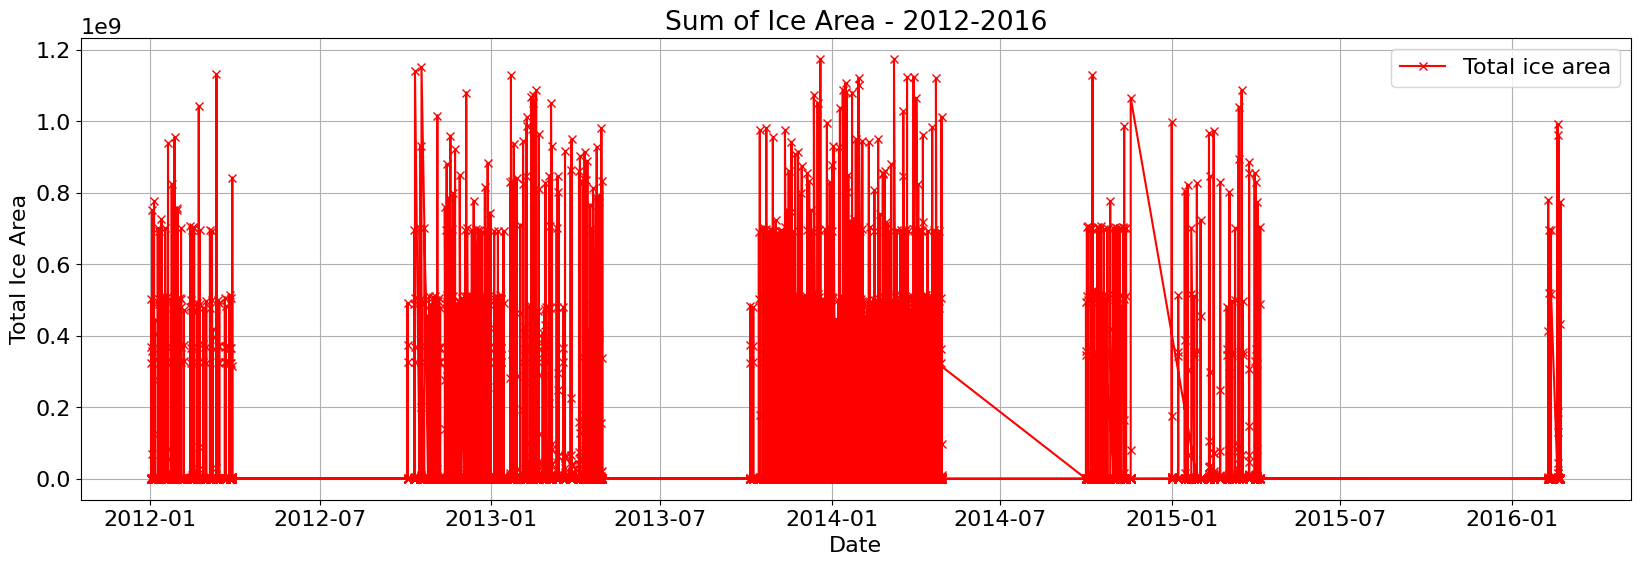

In [203]:
# Plot the results
plt.figure(figsize=(20, 6))
plt.plot(rswinter['date'], rswinter['area'], c= 'red', marker='x', label='Total ice area')
# plt.plot(dates, sums, marker='o', label='Total ice area')
plt.xlabel('Date')
plt.ylabel('Total Ice Area')
# plt.ylim(0,1.3e6)
plt.title('Sum of Ice Area - 2012-2016')
plt.legend()
plt.grid()
plt.show()

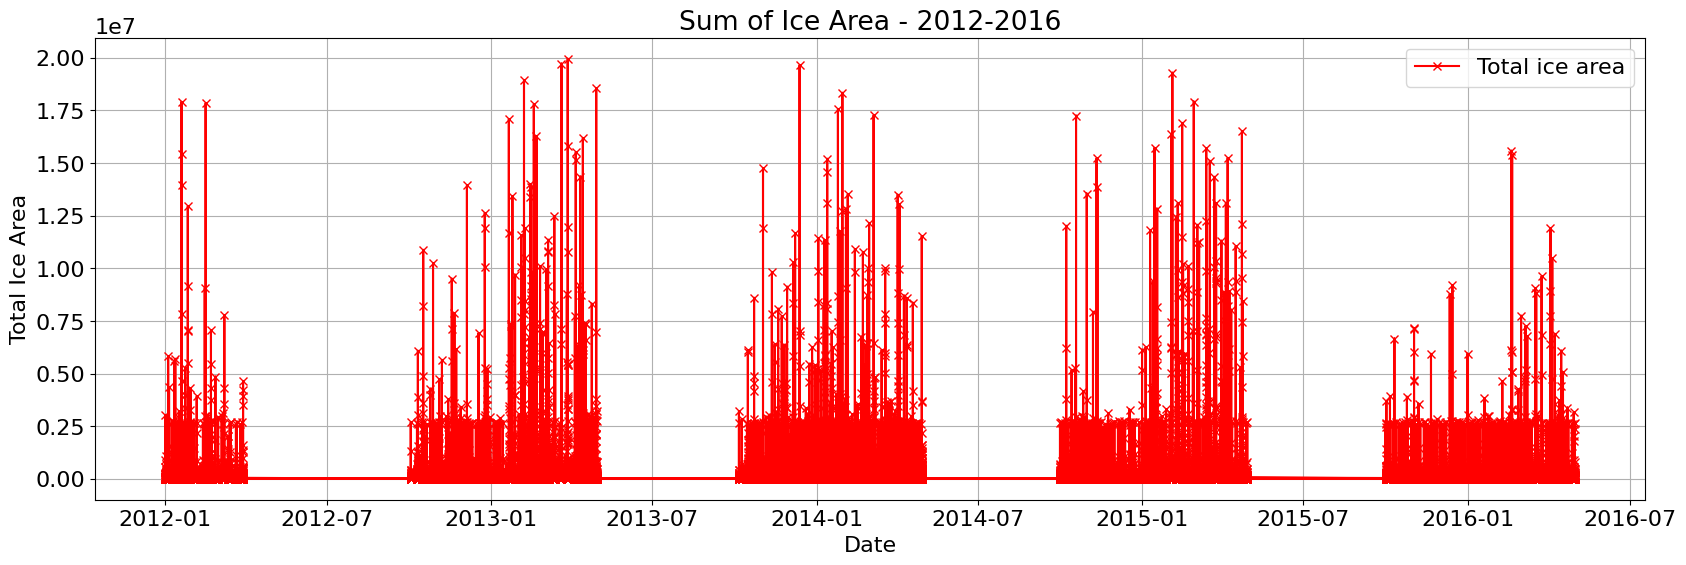

In [204]:
# Plot the results
plt.figure(figsize=(20, 6))
plt.plot(rsw['date'], rsw['area'], c= 'red', marker='x', label='Total ice area')
# plt.plot(dates, sums, marker='o', label='Total ice area')
plt.xlabel('Date')
plt.ylabel('Total Ice Area')
# plt.ylim(0,1.3e6)
plt.title('Sum of Ice Area - 2012-2016')
plt.legend()
plt.grid()
plt.show()

In [205]:
result = rsw.groupby(['date', 'value'])['area'].sum().reset_index()
print(result)

           date  value        area
0    2012-01-02    0.0  14067500.0
1    2012-01-02    1.0   1140000.0
2    2012-01-03    0.0  24877500.0
3    2012-01-03    1.0   7987500.0
4    2012-01-05    0.0  17307500.0
...         ...    ...         ...
1057 2016-04-27    1.0    410000.0
1058 2016-04-29    0.0  16105000.0
1059 2016-04-29    1.0  13635000.0
1060 2016-04-30    0.0  21820000.0
1061 2016-04-30    1.0    992500.0

[1062 rows x 3 columns]


In [206]:
ice_area = result[result['value'] == 1] 
print(ice_area)

           date  value        area
1    2012-01-02    1.0   1140000.0
3    2012-01-03    1.0   7987500.0
5    2012-01-05    1.0  16722500.0
7    2012-01-06    1.0  18317500.0
9    2012-01-09    1.0   1452500.0
...         ...    ...         ...
1053 2016-04-22    1.0   3785000.0
1055 2016-04-23    1.0    680000.0
1057 2016-04-27    1.0    410000.0
1059 2016-04-29    1.0  13635000.0
1061 2016-04-30    1.0    992500.0

[531 rows x 3 columns]


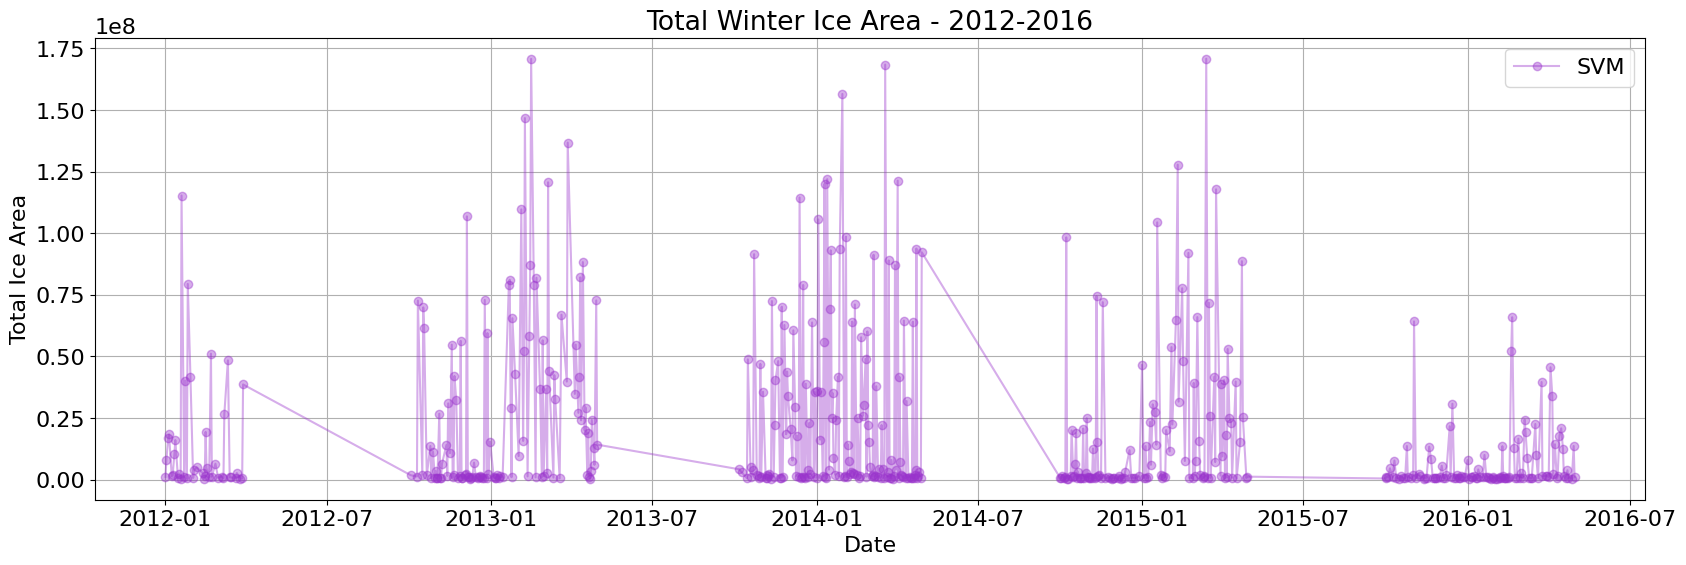

In [207]:
# Plot the results
plt.figure(figsize=(20, 6))
plt.plot(ice_area['date'], ice_area['area'], c='darkorchid', marker='o', alpha=0.4, label='SVM')
plt.xlabel('Date')
plt.ylabel('Total Ice Area')
# plt.ylim(0,1.3e6)
plt.title('Total Winter Ice Area - 2012-2016')
plt.legend()
plt.grid()
# plt.savefig("C:/Users/jullian.williams/Desktop/plots.png", bbox_inches="tight", pad_inches=0.3, transparent=True)
plt.show()

## Summer

In [208]:
input_dir = "C:/Users/jullian.williams/Desktop/RS_Summer/"

dataframes_rs = []

# Loop through all .tif files in the input directory
for subdir, _, files in os.walk(input_dir):
    for filename in files: 
        # Check if the file is an image (e.g., .jpg, .png)
        if filename.endswith(('.tif')):
            input_path = os.path.join(subdir, filename)
             
            with rio.open(input_path) as src_:
                profile = src_.profile  # Save metadata
                transform_ = src_.transform
                crs_=src_.crs
                b1_ = src_.read(1)
                
                def image_to_geodataframe(image_array, transform, crs):
            # Generate shapes (polygons) from the raster array
                    shapes_generator = shapes(image_array, transform=transform_)
                    
                    # Create a GeoDataFrame
                    geometries = []
                    values = []
                    for geom, value in shapes_generator:
                        geometries.append(shape(geom))
                        values.append(value)

                        name, ext = os.path.splitext(filename)
                        raftposition = 17
                        bfposition = 9
                
                        # Create the new file name
                        file_name = f"{filename[:raftposition]}"
                        fname = f"{file_name[bfposition:]}"
                                
                            
                    gdf = gpd.GeoDataFrame({'value': values, 'geometry': geometries, 'date':fname}, crs=crs_)
                    
                    return gdf 
                    
            gdf = image_to_geodataframe(b1_, transform=transform_, crs=crs_)


            gdf['date'] = pd.to_datetime(gdf['date'])
            gdf['area'] = gdf.geometry.area
            gdf['perimeter'] = gdf.geometry.length
            gdf['centroid'] = gdf.geometry.centroid
            # Extract latitude and longitude from centroids
            gdf['longitude'] = gdf.centroid.x
            gdf['latitude'] = gdf.centroid.y
            gdf.set_crs(epsg=32633, inplace=True)

            dataframes_rs.append(gdf)

In [209]:
input_dir = "C:/Users/jullian.williams/Desktop/EW_Summer/"

dataframes_ew = []

# Loop through all .tif files in the input directory
for subdir, _, files in os.walk(input_dir):
    for filename in files: 
        # Check if the file is an image (e.g., .jpg, .png)
        if filename.endswith(('.tif')):
            input_path = os.path.join(subdir, filename)
             
            with rio.open(input_path) as src_:
                profile = src_.profile  # Save metadata
                transform_ = src_.transform
                crs_=src_.crs
                b1_ = src_.read(1)
                
                def image_to_geodataframe(image_array, transform, crs):
            # Generate shapes (polygons) from the raster array
                    shapes_generator = shapes(image_array, transform=transform_)
                    
                    # Create a GeoDataFrame
                    geometries = []
                    values = []
                    for geom, value in shapes_generator:
                        geometries.append(shape(geom))
                        values.append(value)

                        name, ext = os.path.splitext(filename)
                        raftposition = 15
                        bfposition = 7
                
                        # Create the new file name
                        file_name = f"{filename[:raftposition]}"
                        fname = f"{file_name[bfposition:]}"
                                
                            
                    gdf = gpd.GeoDataFrame({'value': values, 'geometry': geometries, 'date':fname}, crs=crs_)
                    
                    return gdf 
                    
            gdf = image_to_geodataframe(b1_, transform=transform_, crs=crs_)


            gdf['date'] = pd.to_datetime(gdf['date'])
            gdf['area'] = gdf.geometry.area
            gdf['perimeter'] = gdf.geometry.length
            gdf['centroid'] = gdf.geometry.centroid
            # Extract latitude and longitude from centroids
            gdf['longitude'] = gdf.centroid.x
            gdf['latitude'] = gdf.centroid.y
            gdf.set_crs(epsg=32633, inplace=True)

            dataframes_ew.append(gdf)

In [210]:
rssummer = pd.concat(dataframes_rs, ignore_index=True)
print(rssummer)

        value                                           geometry       date  \
0         1.0  POLYGON ((498975 8559025, 498975 8558875, 4990... 2012-05-06   
1         1.0  POLYGON ((499475 8559025, 499475 8558975, 4993... 2012-05-06   
2         1.0  POLYGON ((499675 8558775, 499675 8558725, 4997... 2012-05-06   
3         1.0  POLYGON ((499175 8558675, 499175 8558625, 4992... 2012-05-06   
4         1.0  POLYGON ((500825 8558275, 500825 8558225, 5007... 2012-05-06   
...       ...                                                ...        ...   
624020    1.0  POLYGON ((501875 8531075, 501875 8531025, 5019... 2014-09-30   
624021    0.0  POLYGON ((498975 8559025, 498975 8558075, 4990... 2014-09-30   
624022    1.0  POLYGON ((503825 8531075, 503825 8531025, 5039... 2014-09-30   
624023    1.0  POLYGON ((507175 8531075, 507175 8531025, 5072... 2014-09-30   
624024    1.0  POLYGON ((513125 8531125, 513125 8531075, 5129... 2014-09-30   

                area  perimeter                    

In [211]:
ewsummer = pd.concat(dataframes_ew, ignore_index=True)
print(ewsummer)

        value                                           geometry       date  \
0         0.0  POLYGON ((499075 8559025, 499075 8558975, 4991... 2015-05-01   
1         0.0  POLYGON ((499975 8559025, 499975 8558975, 5000... 2015-05-01   
2         0.0  POLYGON ((500125 8559025, 500125 8558925, 5001... 2015-05-01   
3         0.0  POLYGON ((499475 8558975, 499475 8558925, 4995... 2015-05-01   
4         0.0  POLYGON ((499125 8558975, 499125 8558925, 4991... 2015-05-01   
...       ...                                                ...        ...   
267032    1.0  POLYGON ((498975 8559025, 498975 8556825, 4990... 2016-09-30   
267033    0.0  POLYGON ((511125 8531025, 511125 8530975, 5111... 2016-09-30   
267034    0.0  POLYGON ((512675 8531025, 512675 8530975, 5127... 2016-09-30   
267035    1.0  POLYGON ((513925 8531125, 513925 8531075, 5139... 2016-09-30   
267036    1.0  POLYGON ((514375 8531275, 514375 8531125, 5144... 2016-09-30   

               area  perimeter                     

In [212]:
summer = pd.concat([rssummer,ewsummer], ignore_index=True)
print(summer)

        value                                           geometry       date  \
0         1.0  POLYGON ((498975 8559025, 498975 8558875, 4990... 2012-05-06   
1         1.0  POLYGON ((499475 8559025, 499475 8558975, 4993... 2012-05-06   
2         1.0  POLYGON ((499675 8558775, 499675 8558725, 4997... 2012-05-06   
3         1.0  POLYGON ((499175 8558675, 499175 8558625, 4992... 2012-05-06   
4         1.0  POLYGON ((500825 8558275, 500825 8558225, 5007... 2012-05-06   
...       ...                                                ...        ...   
891057    1.0  POLYGON ((498975 8559025, 498975 8556825, 4990... 2016-09-30   
891058    0.0  POLYGON ((511125 8531025, 511125 8530975, 5111... 2016-09-30   
891059    0.0  POLYGON ((512675 8531025, 512675 8530975, 5127... 2016-09-30   
891060    1.0  POLYGON ((513925 8531125, 513925 8531075, 5139... 2016-09-30   
891061    1.0  POLYGON ((514375 8531275, 514375 8531125, 5144... 2016-09-30   

               area  perimeter                     

In [213]:
# rssummer = pd.concat(summer, ignore_index=True)
# print(rssummer)

In [214]:
rss = summer.drop(summer[summer['area'] >= 2e7].index) # Remove wrapper cells
print(rss)

        value                                           geometry       date  \
0         1.0  POLYGON ((498975 8559025, 498975 8558875, 4990... 2012-05-06   
1         1.0  POLYGON ((499475 8559025, 499475 8558975, 4993... 2012-05-06   
2         1.0  POLYGON ((499675 8558775, 499675 8558725, 4997... 2012-05-06   
3         1.0  POLYGON ((499175 8558675, 499175 8558625, 4992... 2012-05-06   
4         1.0  POLYGON ((500825 8558275, 500825 8558225, 5007... 2012-05-06   
...       ...                                                ...        ...   
891056    0.0  POLYGON ((510525 8531025, 510525 8530975, 5105... 2016-09-30   
891058    0.0  POLYGON ((511125 8531025, 511125 8530975, 5111... 2016-09-30   
891059    0.0  POLYGON ((512675 8531025, 512675 8530975, 5127... 2016-09-30   
891060    1.0  POLYGON ((513925 8531125, 513925 8531075, 5139... 2016-09-30   
891061    1.0  POLYGON ((514375 8531275, 514375 8531125, 5144... 2016-09-30   

            area  perimeter                        

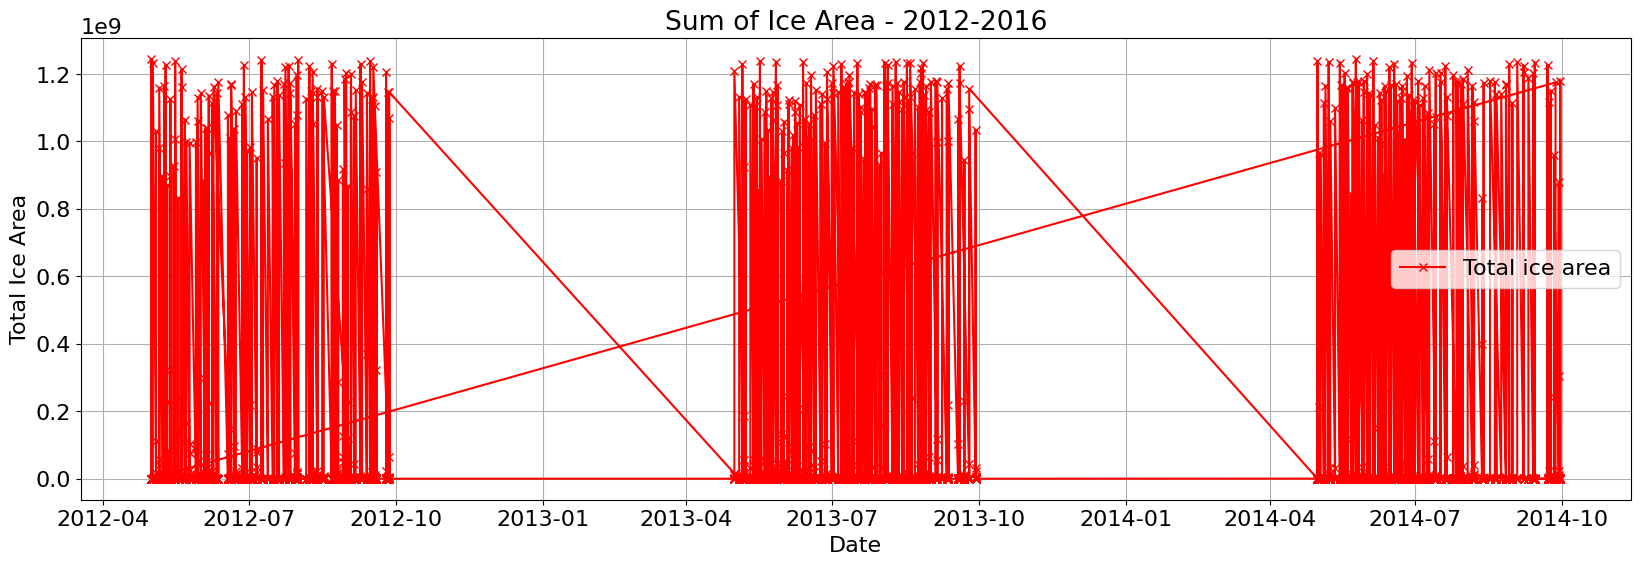

In [215]:
# Plot the results
plt.figure(figsize=(20, 6))
plt.plot(rssummer['date'], rssummer['area'], c= 'red', marker='x', label='Total ice area')
# plt.plot(dates, sums, marker='o', label='Total ice area')
plt.xlabel('Date')
plt.ylabel('Total Ice Area')
# plt.ylim(0,1.3e6)
plt.title('Sum of Ice Area - 2012-2016')
plt.legend()
plt.grid()
plt.show()

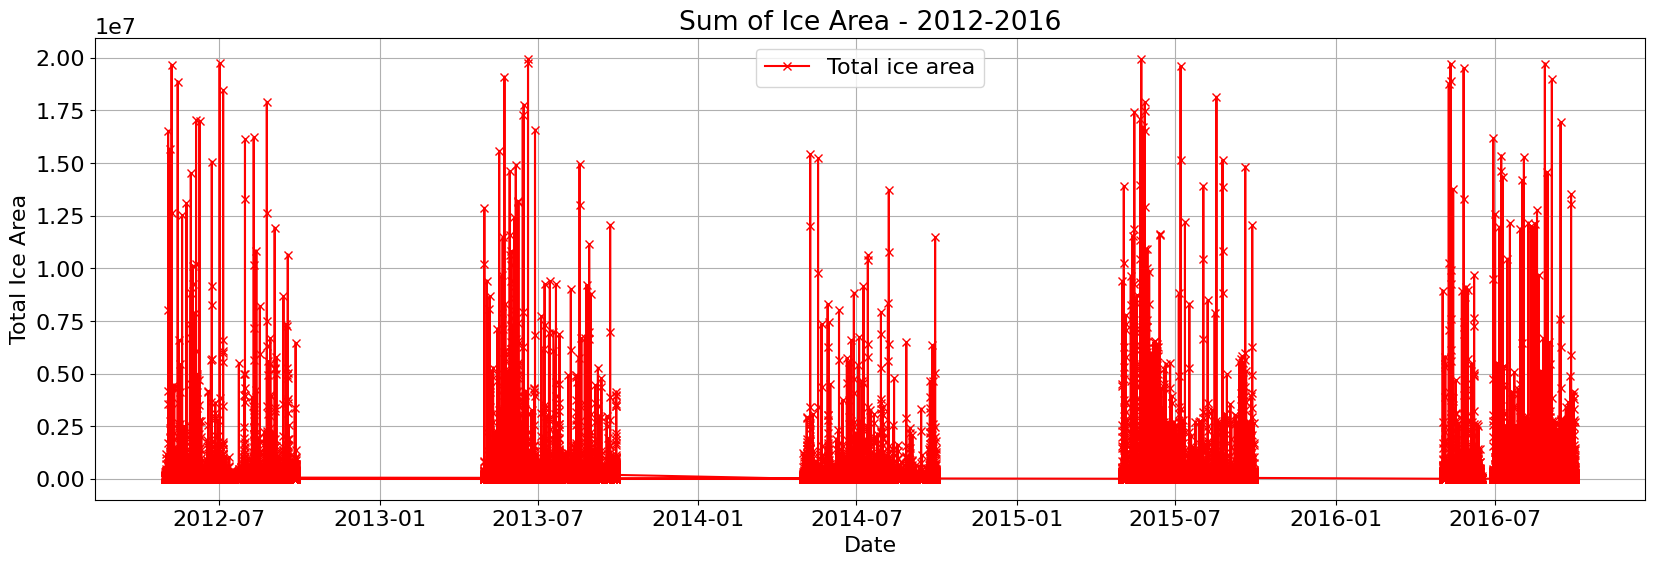

In [216]:
# Plot the results
plt.figure(figsize=(20, 6))
plt.plot(rss['date'], rss['area'], c= 'red', marker='x', label='Total ice area')
# plt.plot(dates, sums, marker='o', label='Total ice area')
plt.xlabel('Date')
plt.ylabel('Total Ice Area')
# plt.ylim(0,1.3e6)
plt.title('Sum of Ice Area - 2012-2016')
plt.legend()
plt.grid()
plt.show()

In [217]:
result_ = rss.groupby(['date', 'value'])['area'].sum().reset_index()
print(result_)

          date  value        area
0   2012-05-01    0.0  20285000.0
1   2012-05-02    0.0  32780000.0
2   2012-05-04    0.0  13797500.0
3   2012-05-04    1.0  54702500.0
4   2012-05-06    0.0  20147500.0
..         ...    ...         ...
804 2016-09-28    1.0   2035000.0
805 2016-09-29    0.0  14112500.0
806 2016-09-29    1.0  47152500.0
807 2016-09-30    0.0  29625000.0
808 2016-09-30    1.0   1995000.0

[809 rows x 3 columns]


In [218]:
ice_area_ = result_[result_['value'] == 1] 
print(ice_area_)

          date  value         area
3   2012-05-04    1.0   54702500.0
5   2012-05-06    1.0  111597500.0
7   2012-05-08    1.0   52832500.0
9   2012-05-09    1.0    1305000.0
12  2012-05-11    1.0   45520000.0
..         ...    ...          ...
800 2016-09-25    1.0   54797500.0
802 2016-09-26    1.0   95080000.0
804 2016-09-28    1.0    2035000.0
806 2016-09-29    1.0   47152500.0
808 2016-09-30    1.0    1995000.0

[397 rows x 3 columns]


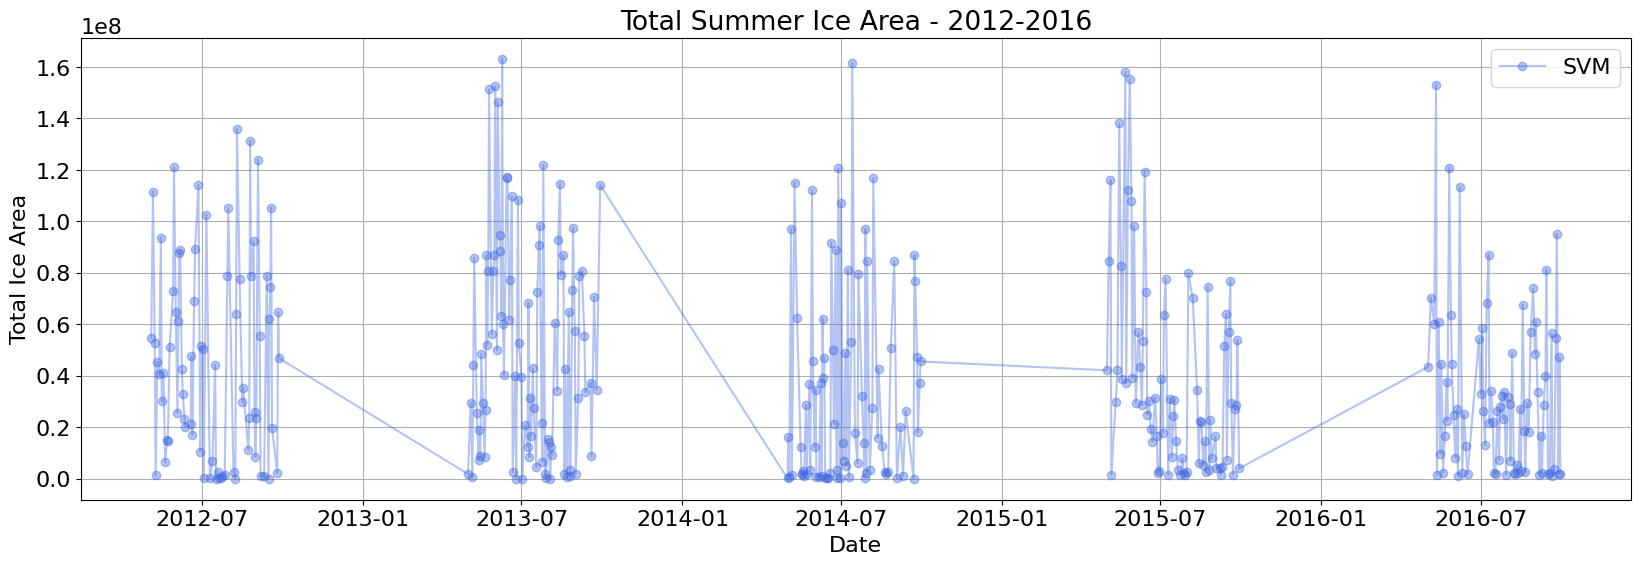

In [219]:
# Plot the results
plt.figure(figsize=(20, 6))
plt.plot(ice_area_['date'], ice_area_['area'], c='royalblue', marker='o', alpha=0.4, label='SVM')
plt.xlabel('Date')
plt.ylabel('Total Ice Area')
# plt.ylim(0,1.3e6)
plt.title('Total Summer Ice Area - 2012-2016')
plt.legend()
plt.grid()
# plt.savefig("C:/Users/jullian.williams/Desktop/plots.png", bbox_inches="tight", pad_inches=0.3, transparent=True)
plt.show()

# All seasons

## SVM

In [2]:
input_dir = "C:/Users/jullian.williams/Desktop/RS_12_16/"

df = []

# Loop through all .tif files in the input directory
for subdir, _, files in os.walk(input_dir):
    for filename in files: 
        # Check if the file is an image (e.g., .jpg, .png)
        if filename.endswith(('.tif')):
            input_path = os.path.join(subdir, filename)
             
            with rio.open(input_path) as src_:
                profile = src_.profile  # Save metadata
                transform_ = src_.transform
                crs_=src_.crs
                b1_ = src_.read(1)
                
                def image_to_geodataframe(image_array, transform, crs):
            # Generate shapes (polygons) from the raster array
                    shapes_generator = shapes(image_array, transform=transform_)
                    
                    # Create a GeoDataFrame
                    geometries = []
                    values = []
                    for geom, value in shapes_generator:
                        geometries.append(shape(geom))
                        values.append(value)

                        name, ext = os.path.splitext(filename)
                        raftposition = 17
                        bfposition = 9
                
                        # Create the new file name
                        file_name = f"{filename[:raftposition]}"
                        fname = f"{file_name[bfposition:]}"
                                
                            
                    gdf = gpd.GeoDataFrame({'value': values, 'geometry': geometries, 'date':fname}, crs=crs_)
                    
                    return gdf 
                    
            gdf = image_to_geodataframe(b1_, transform=transform_, crs=crs_)


            gdf['date'] = pd.to_datetime(gdf['date'])
            gdf['area'] = gdf.geometry.area
            gdf['perimeter'] = gdf.geometry.length
            gdf['centroid'] = gdf.geometry.centroid
            # Extract latitude and longitude from centroids
            gdf['longitude'] = gdf.centroid.x
            gdf['latitude'] = gdf.centroid.y
            gdf.set_crs(epsg=32633, inplace=True)

            df.append(gdf)

In [3]:
rs2 = pd.concat(df, ignore_index=True)
print(rs2)

         value                                           geometry       date  \
0          0.0  POLYGON ((500275 8558875, 500275 8558825, 5003... 2012-02-03   
1          1.0  POLYGON ((500825 8558275, 500825 8558225, 5007... 2012-02-03   
2          1.0  POLYGON ((501175 8558075, 501175 8558025, 5010... 2012-02-03   
3          0.0  POLYGON ((499575 8557625, 499575 8557575, 4996... 2012-02-03   
4          0.0  POLYGON ((500575 8557575, 500575 8557525, 5006... 2012-02-03   
...        ...                                                ...        ...   
1812786    1.0  POLYGON ((499425 8549075, 499425 8549025, 4993... 2016-03-01   
1812787    0.0  POLYGON ((510575 8531025, 510575 8530975, 5107... 2016-03-01   
1812788    0.0  POLYGON ((498975 8559025, 498975 8558275, 4990... 2016-03-01   
1812789    0.0  POLYGON ((511875 8531025, 511875 8530975, 5119... 2016-03-01   
1812790    1.0  POLYGON ((512925 8531075, 512925 8531025, 5128... 2016-03-01   

                area  perimeter        

In [220]:
rs2 =  pd.concat([winter, summer], ignore_index=True)
print(rs2)

         value                                           geometry       date  \
0          0.0  POLYGON ((500275 8558875, 500275 8558825, 5003... 2012-02-03   
1          1.0  POLYGON ((500825 8558275, 500825 8558225, 5007... 2012-02-03   
2          1.0  POLYGON ((501175 8558075, 501175 8558025, 5010... 2012-02-03   
3          0.0  POLYGON ((499575 8557625, 499575 8557575, 4996... 2012-02-03   
4          0.0  POLYGON ((500575 8557575, 500575 8557525, 5006... 2012-02-03   
...        ...                                                ...        ...   
2288337    1.0  POLYGON ((498975 8559025, 498975 8556825, 4990... 2016-09-30   
2288338    0.0  POLYGON ((511125 8531025, 511125 8530975, 5111... 2016-09-30   
2288339    0.0  POLYGON ((512675 8531025, 512675 8530975, 5127... 2016-09-30   
2288340    1.0  POLYGON ((513925 8531125, 513925 8531075, 5139... 2016-09-30   
2288341    1.0  POLYGON ((514375 8531275, 514375 8531125, 5144... 2016-09-30   

                area  perimeter        

In [221]:
rs2 = rs2.drop(rs2[rs2['area'] >= 2e7].index) # Remove wrapper cells
print(rs2)

         value                                           geometry       date  \
0          0.0  POLYGON ((500275 8558875, 500275 8558825, 5003... 2012-02-03   
1          1.0  POLYGON ((500825 8558275, 500825 8558225, 5007... 2012-02-03   
2          1.0  POLYGON ((501175 8558075, 501175 8558025, 5010... 2012-02-03   
3          0.0  POLYGON ((499575 8557625, 499575 8557575, 4996... 2012-02-03   
4          0.0  POLYGON ((500575 8557575, 500575 8557525, 5006... 2012-02-03   
...        ...                                                ...        ...   
2288336    0.0  POLYGON ((510525 8531025, 510525 8530975, 5105... 2016-09-30   
2288338    0.0  POLYGON ((511125 8531025, 511125 8530975, 5111... 2016-09-30   
2288339    0.0  POLYGON ((512675 8531025, 512675 8530975, 5127... 2016-09-30   
2288340    1.0  POLYGON ((513925 8531125, 513925 8531075, 5139... 2016-09-30   
2288341    1.0  POLYGON ((514375 8531275, 514375 8531125, 5144... 2016-09-30   

            area  perimeter            

In [222]:
rt = rs2.groupby(['date', 'value'])['area'].sum().reset_index()
print(rt)

           date  value        area
0    2012-01-02    0.0  14067500.0
1    2012-01-02    1.0   1140000.0
2    2012-01-03    0.0  24877500.0
3    2012-01-03    1.0   7987500.0
4    2012-01-05    0.0  17307500.0
...         ...    ...         ...
1866 2016-09-28    1.0   2035000.0
1867 2016-09-29    0.0  14112500.0
1868 2016-09-29    1.0  47152500.0
1869 2016-09-30    0.0  29625000.0
1870 2016-09-30    1.0   1995000.0

[1871 rows x 3 columns]


In [223]:
iceara = rt[rt['value'] == 1] 
print(iceara)

           date  value        area
1    2012-01-02    1.0   1140000.0
3    2012-01-03    1.0   7987500.0
5    2012-01-05    1.0  16722500.0
7    2012-01-06    1.0  18317500.0
9    2012-01-09    1.0   1452500.0
...         ...    ...         ...
1862 2016-09-25    1.0  54797500.0
1864 2016-09-26    1.0  95080000.0
1866 2016-09-28    1.0   2035000.0
1868 2016-09-29    1.0  47152500.0
1870 2016-09-30    1.0   1995000.0

[928 rows x 3 columns]


In [224]:
r = rs2.groupby(['date'])['area'].sum().reset_index()
print(r)

          date         area
0   2012-01-02   15207500.0
1   2012-01-03   32865000.0
2   2012-01-05   34030000.0
3   2012-01-06   27402500.0
4   2012-01-09   17010000.0
..         ...          ...
948 2016-09-25   55735000.0
949 2016-09-26  114262500.0
950 2016-09-28   33822500.0
951 2016-09-29   61265000.0
952 2016-09-30   31620000.0

[953 rows x 2 columns]


In [225]:
xm = pd.merge(iceara,r, on='date',how='outer').fillna(0)
xm['perc'] = (xm['area_x']/xm['area_y'])*100
xm['julian'] = xm['date'].dt.strftime('%j')
print(xm)

          date  value      area_x       area_y       perc julian
0   2012-01-02    1.0   1140000.0   15207500.0   7.496301    002
1   2012-01-03    1.0   7987500.0   32865000.0  24.303971    003
2   2012-01-05    1.0  16722500.0   34030000.0  49.140464    005
3   2012-01-06    1.0  18317500.0   27402500.0  66.846091    006
4   2012-01-09    1.0   1452500.0   17010000.0   8.539095    009
..         ...    ...         ...          ...        ...    ...
948 2016-09-25    1.0  54797500.0   55735000.0  98.317933    269
949 2016-09-26    1.0  95080000.0  114262500.0  83.211902    270
950 2016-09-28    1.0   2035000.0   33822500.0   6.016705    272
951 2016-09-29    1.0  47152500.0   61265000.0  76.964825    273
952 2016-09-30    1.0   1995000.0   31620000.0   6.309298    274

[953 rows x 6 columns]


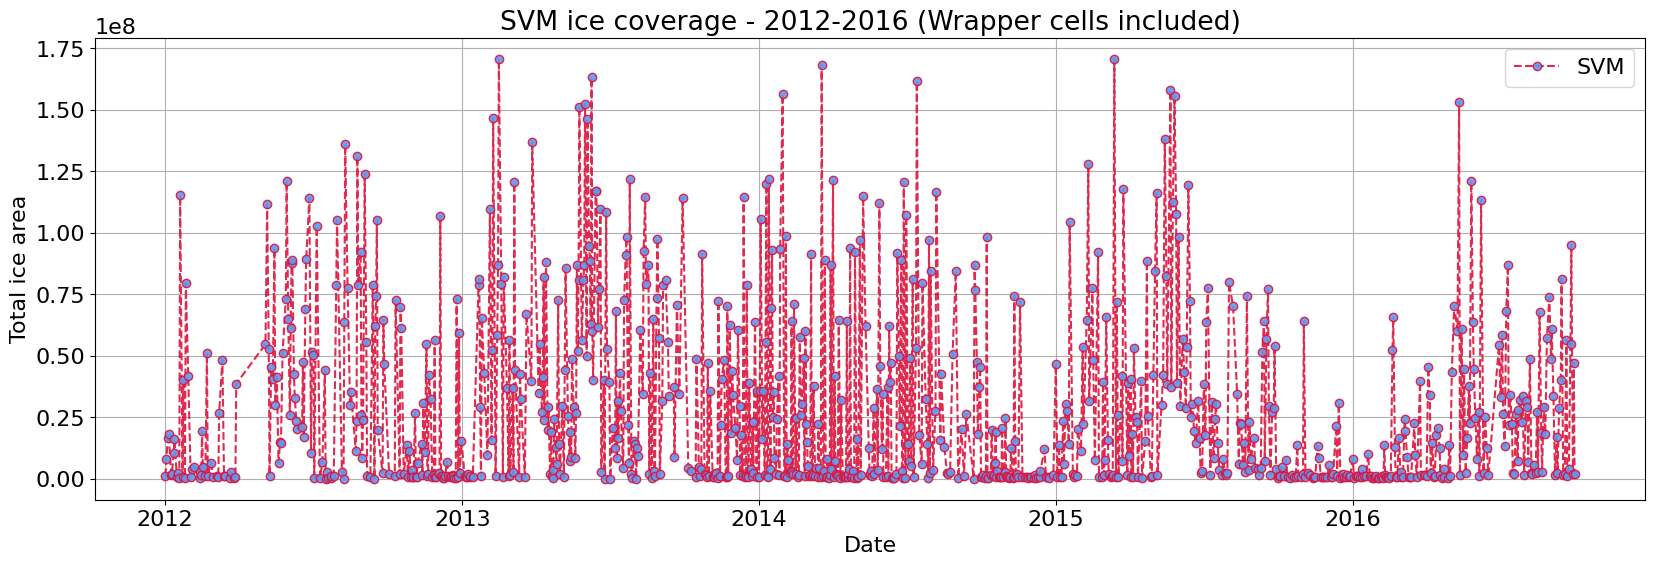

In [226]:
# Plot the results
plt.figure(figsize=(20, 6))
plt.plot(iceara['date'], iceara['area'], c='crimson', linestyle='--',markerfacecolor='cornflowerblue', marker='o', alpha=0.9, label='SVM')
plt.xlabel('Date')
plt.ylabel('Total ice area')
# plt.ylim(0,1.3e6)
plt.title('SVM ice coverage - 2012-2016 (Wrapper cells included)')
plt.legend()
plt.grid()
# plt.savefig("C:/Users/jullian.williams/Desktop/plots.png", bbox_inches="tight", pad_inches=0.3, transparent=True)
plt.show()

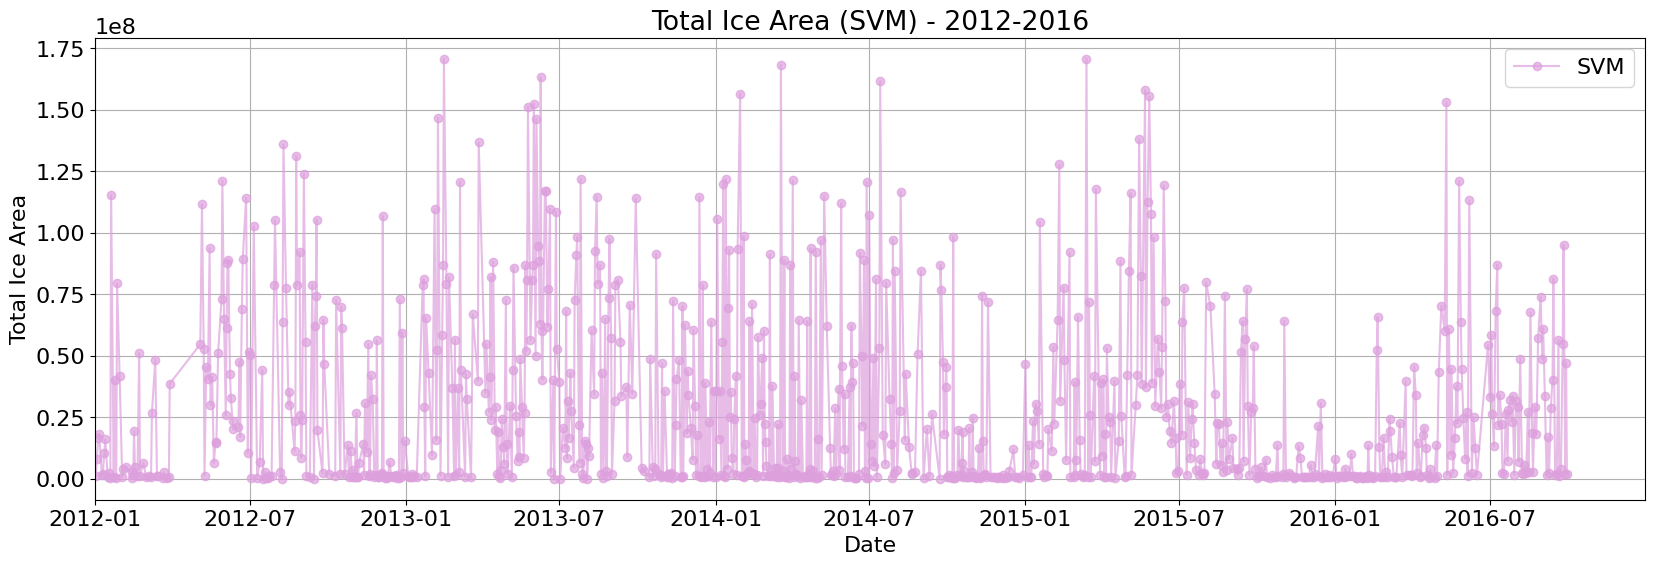

In [227]:
# Plot the results
plt.figure(figsize=(20, 6))
plt.plot(iceara['date'], iceara['area'], c='plum', marker='o', alpha=0.7, label='SVM')
plt.xlabel('Date')
plt.ylabel('Total Ice Area')
start_date = datetime(2012, 1, 1)
end_date = datetime(2016, 12, 31)
plt.xlim(start_date, end_date)
# plt.ylim(0,1.3e6)
plt.title('Total Ice Area (SVM) - 2012-2016')
plt.legend()
plt.grid()
# plt.savefig("C:/Users/jullian.williams/Desktop/plots.png", bbox_inches="tight", pad_inches=0.3, transparent=True)
plt.show()

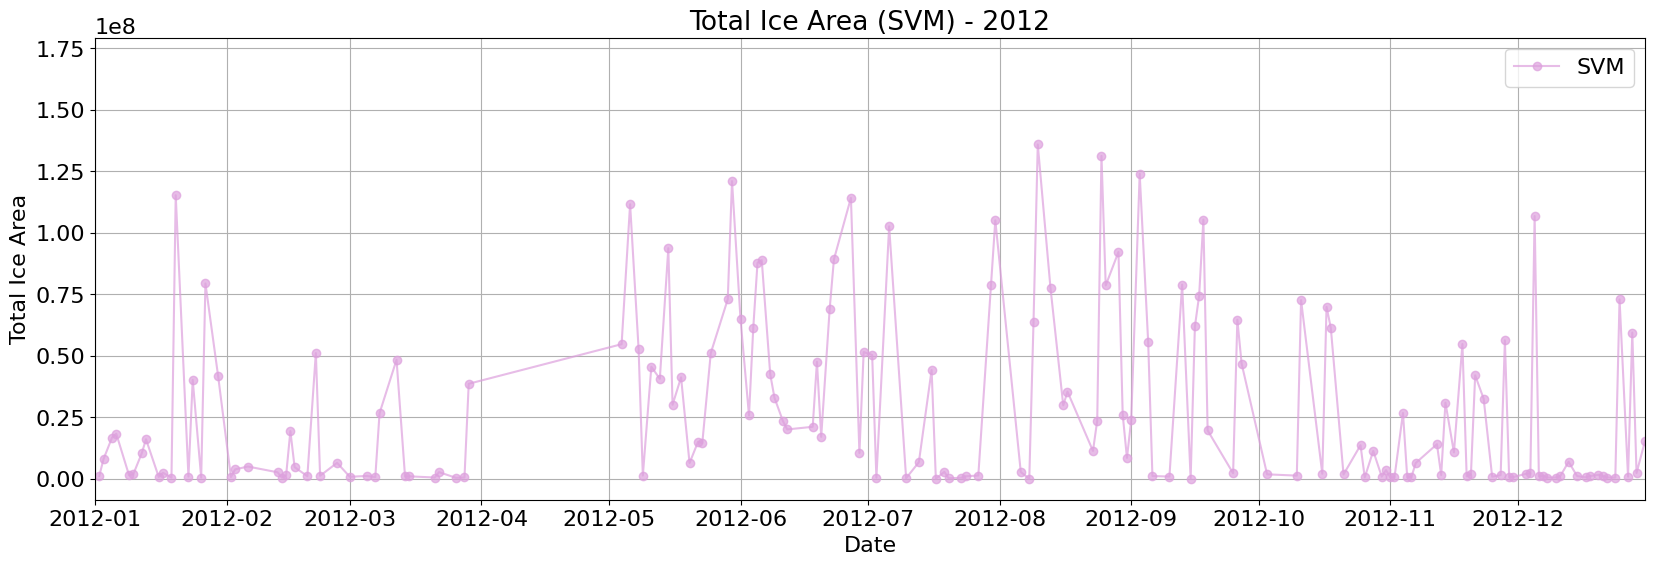

In [228]:
# Plot the results
plt.figure(figsize=(20, 6))
plt.plot(iceara['date'], iceara['area'], c='plum', marker='o', alpha=0.7, label='SVM')
plt.xlabel('Date')
plt.ylabel('Total Ice Area')
start_date = datetime(2012, 1, 1)
end_date = datetime(2012, 12, 31)
plt.xlim(start_date, end_date)
# plt.ylim(0,1.3e6)
plt.title('Total Ice Area (SVM) - 2012')
plt.legend()
plt.grid()
# plt.savefig("C:/Users/jullian.williams/Desktop/plots2a.png", bbox_inches="tight", pad_inches=0.3, transparent=True)
plt.show()

C:\Users\jullian.williams\AppData\Local\Temp\ipykernel_10716\723868691.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


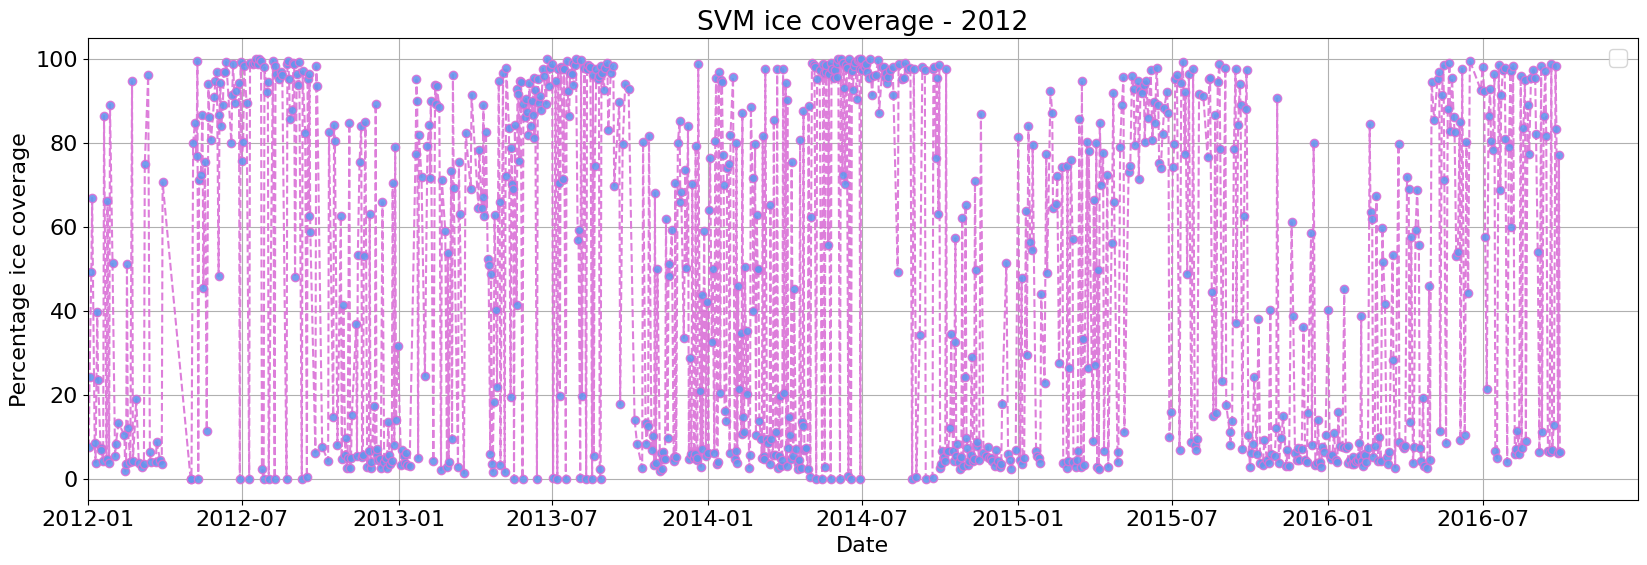

In [229]:
# Plot the results
plt.figure(figsize=(20, 6))
plt.plot(xm['date'], xm['perc'], c='orchid', linestyle='--', marker='o',markerfacecolor='cornflowerblue', alpha=0.9)
plt.xlabel('Date')
plt.ylabel('Percentage ice coverage')
start_date = datetime(2012, 1, 1)
end_date = datetime(2016, 12, 31) #(2015, 4, 30) 
plt.xlim(start_date, end_date)
# plt.ylim(0,1.3e6)
plt.title('SVM ice coverage - 2012')
plt.legend()
plt.grid()
# plt.savefig("C:/Users/jullian.williams/Desktop/plots.png", bbox_inches="tight", pad_inches=0.3, transparent=True)
plt.show()

#### Linear regression

In [113]:
print(xm['perc'].dtype)

float64


In [230]:
y = xm['area_y'].to_numpy()
stlist = xm['julian'].to_numpy()
x = [float(i) for i in stlist]
x = np.array(x)
print(x)

[  2.   3.   5.   6.   9.  10.  12.  13.  16.  17.  19.  20.  23.  24.
  26.  27.  30.  33.  34.  37.  44.  45.  46.  47.  48.  51.  53.  54.
  58.  61.  65.  67.  68.  72.  74.  75.  81.  82.  86.  88.  89. 122.
 123. 125. 127. 129. 130. 131. 132. 134. 136. 137. 139. 141. 143. 144.
 146. 150. 151. 153. 155. 156. 157. 158. 160. 161. 163. 164. 170. 171.
 172. 174. 175. 179. 180. 181. 182. 184. 185. 188. 191. 192. 195. 198.
 199. 201. 202. 205. 206. 208. 209. 212. 213. 214. 219. 221. 222. 223.
 226. 229. 230. 235. 236. 237. 238. 239. 242. 243. 244. 245. 247. 249.
 250. 253. 254. 257. 259. 260. 261. 262. 263. 269. 270. 271. 277. 284.
 285. 290. 291. 292. 295. 299. 300. 302. 304. 305. 306. 307. 309. 310.
 311. 312. 317. 318. 319. 321. 323. 324. 325. 326. 328. 330. 332. 333.
 334. 335. 338. 339. 340. 341. 342. 343. 345. 346. 348. 350. 352. 353.
 355. 356. 357. 359. 360. 362. 363. 364. 366.   4.   5.   7.   8.  10.
  11.  14.  21.  22.  23.  24.  25.  28.  32.  35.  37.  38.  39.  42.
  44. 

In [231]:
def calc_linreg_coef(x,y):
    if(np.size(x) !=np.size(y)):
        sys.exit("Length of x and y are not the same")

    #Number of observations
    n = np.size(x)

    sx = np.sum(x)
    sy = np.sum(y)
    
    sx2 = np.inner(x,x)
    sxy = np.inner(x,y)
    sy2 = np.inner(y,y)

    #Calculation of regression coefficients
    a1 = (n*sxy - sx*sy)/(n*sx2 - sx**2)
    a0 = (sy/n) - (a1*sx)/n

    r2 = ((n*sxy-sx*sy)/np.sqrt(n*sx2-sx**2)/np.sqrt(n*sy2-sy**2))**2;
          
    return (a0, a1, r2)
        

In [232]:
a0, a1, r2 = calc_linreg_coef(x,y)

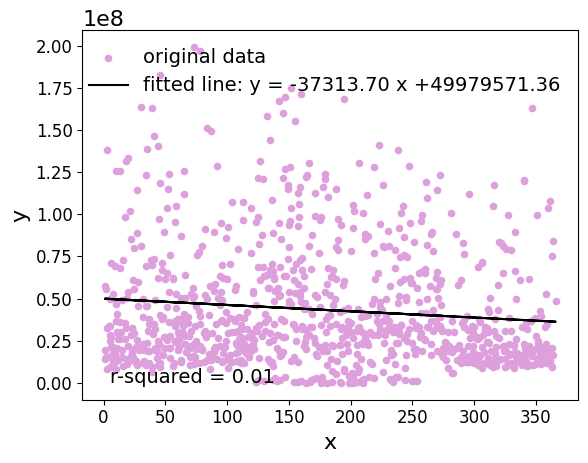

In [233]:
plt.scatter(x,y, c= 'plum', marker='o', s=20, label = 'original data')
y_pred = a0 + a1*x
plt.plot(x,y_pred, color = 'k', label = 'fitted line: y = %.2f x +%.2f'%(a1,a0)) 
plt.text(5,5,'r-squared = %.2f'%r2, fontsize = 14) 
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize =16)
plt.tick_params(axis='both', which='major', labelsize = 12)
plt.legend(loc='upper right', fontsize = 14, frameon=False)
plt.show()

#### Correlations and Fourier Analysis

In [234]:
mty = (rs2.groupby([rs2['date'].dt.month,'value']))['area'].mean().unstack()
mty

value          0.0            1.0
date                             
1      7717.327434  112645.904720
2      7391.191383  140397.050742
3      7868.167776  128441.560627
4      7736.300090  133976.364847
5      6468.216116  107396.503963
6      6067.805874   85416.039690
7      6881.228776   72710.657489
8      6930.206040   69572.198331
9      6773.825967   66749.262270
10     8261.924989   72987.792044
11     7909.301778   89200.476810
12     8321.443500   78580.119889

In [264]:
mty = (rt.groupby([rt['date'].dt.month,'value']))['area'].mean().unstack()
mty

value           0.0           1.0
date                             
1      1.817314e+07  2.370017e+07
2      2.142229e+07  2.804003e+07
3      2.018857e+07  2.326515e+07
4      1.797000e+07  2.118237e+07
5      1.230880e+07  4.984604e+07
6      8.839969e+06  4.776527e+07
7      9.401599e+06  3.205779e+07
8      1.101556e+07  3.672848e+07
9      1.410812e+07  3.631912e+07
10     1.788214e+07  1.118597e+07
11     1.931462e+07  1.409490e+07
12     1.933832e+07  1.254700e+07

In [235]:
icemty = (rs2.groupby([rs2['date'].dt.month,'value']))['area'].mean().unstack()
icemty

value          0.0            1.0
date                             
1      7717.327434  112645.904720
2      7391.191383  140397.050742
3      7868.167776  128441.560627
4      7736.300090  133976.364847
5      6468.216116  107396.503963
6      6067.805874   85416.039690
7      6881.228776   72710.657489
8      6930.206040   69572.198331
9      6773.825967   66749.262270
10     8261.924989   72987.792044
11     7909.301778   89200.476810
12     8321.443500   78580.119889

In [267]:
icemty = (rt.groupby([rt['date'].dt.month,'value']))['area'].mean().unstack()
icemty

value           0.0           1.0
date                             
1      1.817314e+07  2.370017e+07
2      2.142229e+07  2.804003e+07
3      2.018857e+07  2.326515e+07
4      1.797000e+07  2.118237e+07
5      1.230880e+07  4.984604e+07
6      8.839969e+06  4.776527e+07
7      9.401599e+06  3.205779e+07
8      1.101556e+07  3.672848e+07
9      1.410812e+07  3.631912e+07
10     1.788214e+07  1.118597e+07
11     1.931462e+07  1.409490e+07
12     1.933832e+07  1.254700e+07

In [236]:
iceyrl = (rs2.groupby([rs2['date'].dt.year,'value']))['area'].mean().unstack()
iceyrl

value          0.0            1.0
date                             
2012   6851.530374   78643.834487
2013   6688.632002   90854.936912
2014   7499.454787   74036.661167
2015   8059.133860  141348.961458
2016   9190.107195   96837.105646

In [284]:
iceyrl = (rt.groupby([rt['date'].dt.year,'value']))['area'].mean().unstack()
iceyrl

value           0.0           1.0
date                             
2012   1.632837e+07  2.839604e+07
2013   1.779350e+07  3.981740e+07
2014   1.525021e+07  2.538970e+07
2015   1.462508e+07  2.703473e+07
2016   1.386881e+07  2.083908e+07

In [285]:
cormty = mty.corr()
corimty = icemty.corr()
coriyrl = iceyrl.corr()
cormty

value       0.0       1.0
value                    
0.0    1.000000  0.617313
1.0    0.617313  1.000000

In [274]:
corimty

value       0.0       1.0
value                    
0.0    1.000000 -0.759646
1.0   -0.759646  1.000000

In [286]:
coriyrl

value       0.0       1.0
value                    
0.0    1.000000  0.937435
1.0    0.937435  1.000000

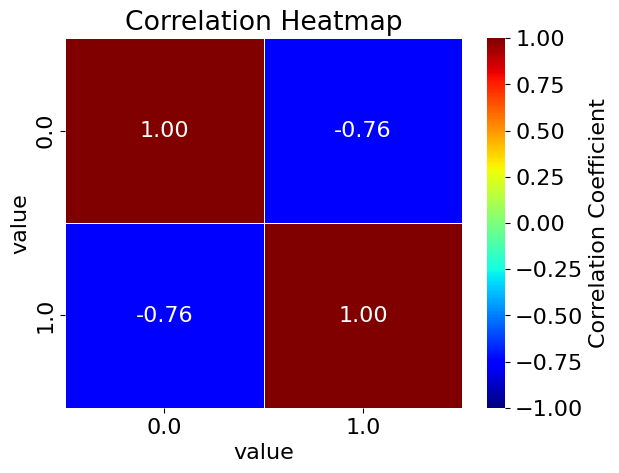

In [266]:
sns.heatmap(
    cormty, 
    annot=True, 
    fmt=".2f",  # Format for annotations:- decimal places
    cmap="jet",  # Custom color map
    linewidths=0.5,  # separation of blocks
    vmin = -1,
    vmax = 1,
    cbar_kws={'label': 'Correlation Coefficient'}  # Customize color bar
)
plt.title('Correlation Heatmap')
plt.show()

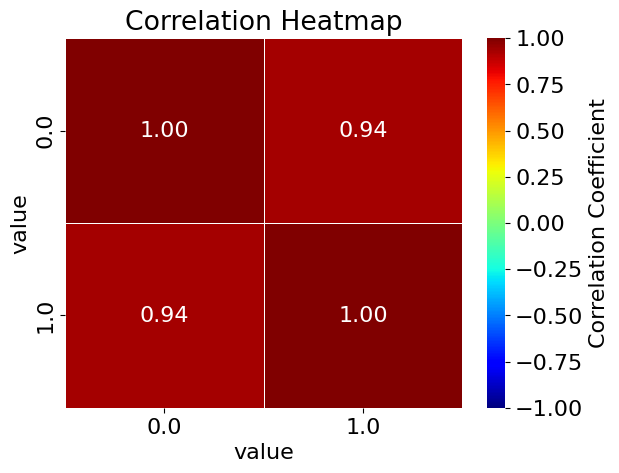

In [275]:
sns.heatmap(
    coriyrl, 
    annot=True, 
    fmt=".2f",  # Format for annotations:- decimal places
    cmap="jet",  # Custom color map
    linewidths=0.5,  # separation of blocks
    vmin = -1,
    vmax = 1,
    cbar_kws={'label': 'Correlation Coefficient'}  # Customize color bar
)
plt.title('Correlation Heatmap')
plt.show()

In [242]:
vt = (rs2.groupby([rs2['date'].dt.year,'value']))['area'].mean().unstack()

In [243]:
vt1 = vt[1]
vt1 = vt1.to_numpy()
vt1

array([ 78643.83448731,  90854.9369119 ,  74036.66116717, 141348.96145824,
        96837.10564582])

In [244]:
vtft = fft(vt1)
vtft

array([481721.49967045    -0.j        , -37606.7637014 +45254.55796495j,
        -6644.39991556-60501.57126012j,  -6644.39991556+60501.57126012j,
       -37606.7637014 -45254.55796495j])

In [245]:
N = len(vtft)
n=np.arange(N)
sr=1/31556952 #placed in terms of seconds in year instead of # of years since hertz is in seconds but the plot looks virtually no different when run all the way through to the reconstruction plot
T = N/sr
freq = n/T

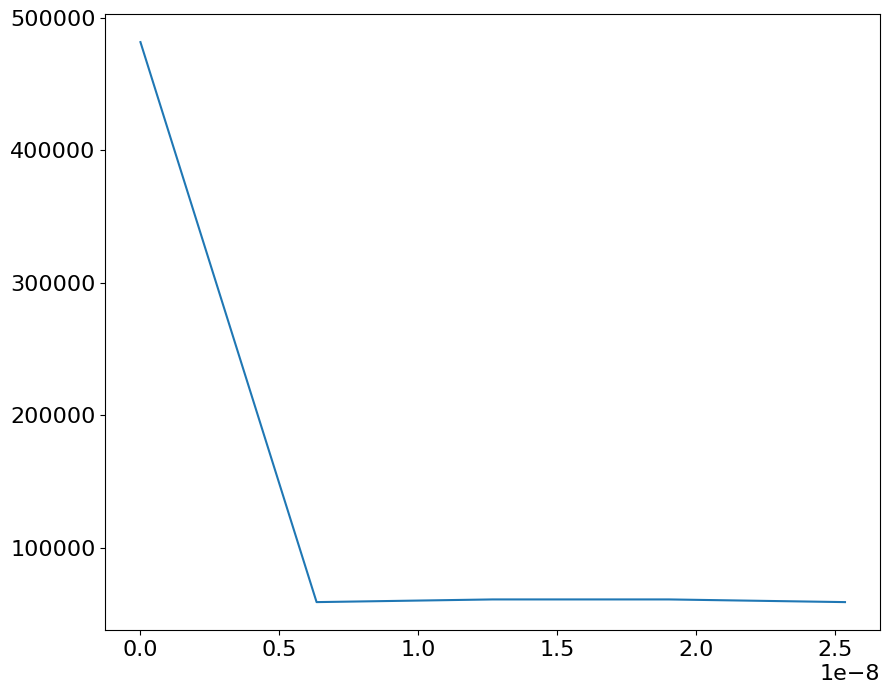

In [246]:
plt.figure(figsize=(10,8))
plt.plot(freq,np.abs(vtft)) #plot power spectrum as well

Text(0, 0.5, 'FFT amplitude')

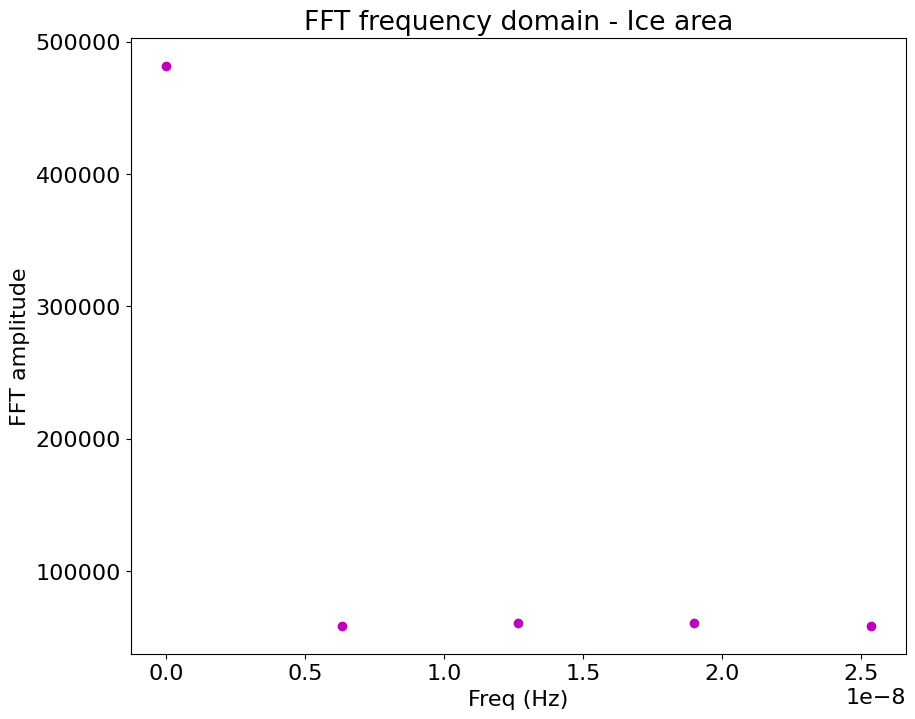

In [247]:
plt.figure(figsize=(10,8))
plt.plot(freq,np.abs(vtft),'mo') #plot power spectrum as well
plt.xlabel('Freq (Hz)')
plt.title('FFT frequency domain - Ice area')
plt.ylabel('FFT amplitude')

C:\Users\jullian.williams\AppData\Local\Temp\ipykernel_10716\511579271.py:11: RuntimeWarning: divide by zero encountered in divide
  np.allclose(peak_freq, 1./freq)


[]

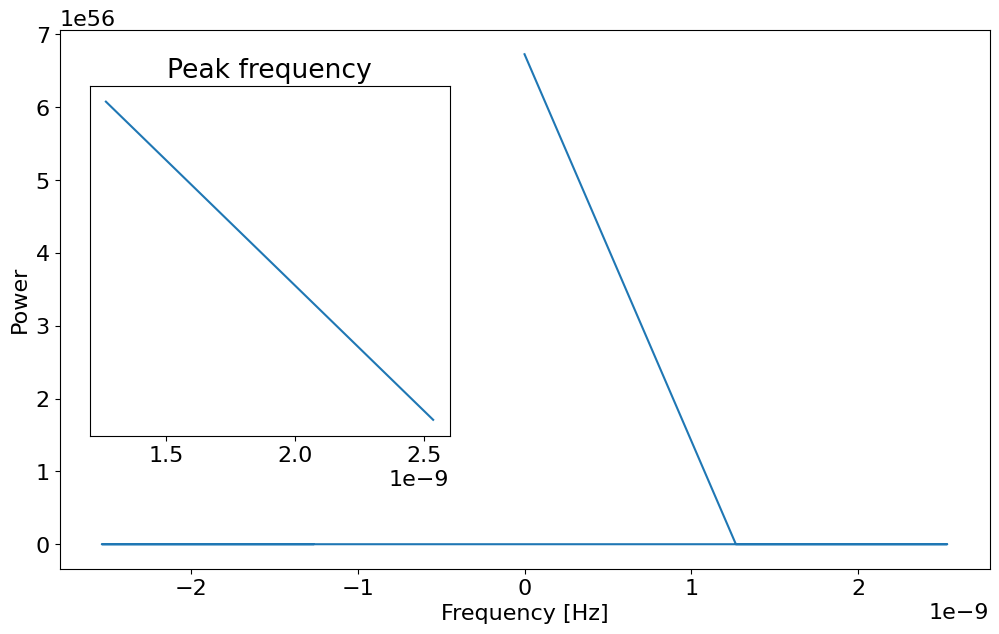

In [248]:
power = np.abs(vtft)**10
sample_freq = fftpack.fftfreq(vt1.size, d=T)
plt.figure(figsize=(12,7))
plt.plot(sample_freq, power)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')

pos_mask = np.where(sample_freq > 0)
freqs = sample_freq[pos_mask]
peak_freq = freqs[power[pos_mask].argmax()]
np.allclose(peak_freq, 1./freq)
axes = plt.axes([0.15, 0.3, 0.3, 0.5])
plt.title('Peak frequency')
plt.plot(freqs[:2], power[:2])
plt.setp(axes, yticks=[])

C:\Users\jullian.williams\.conda\envs\geospatial\lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\jullian.williams\.conda\envs\geospatial\lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


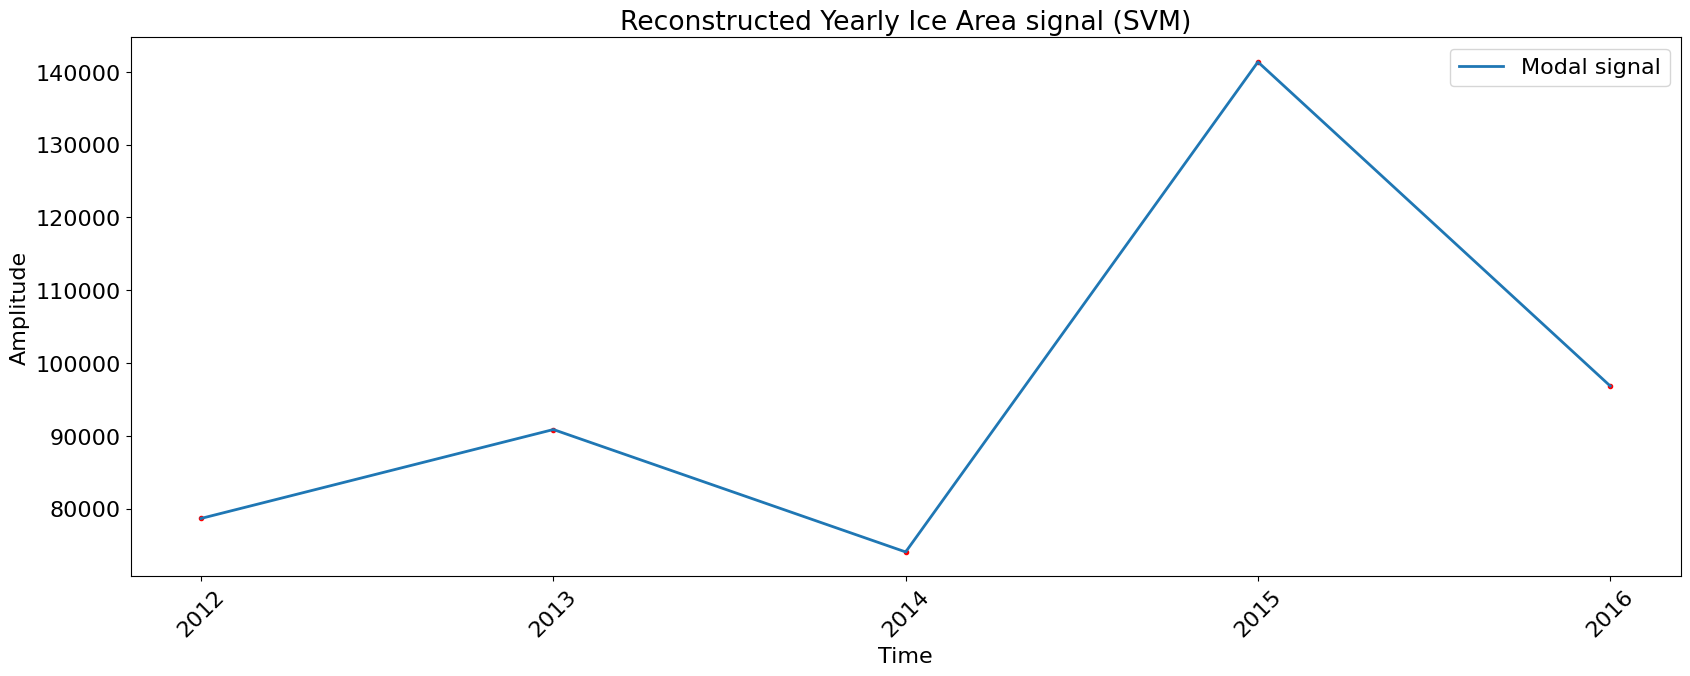

In [255]:
high_freq_fft = vtft.copy()
high_freq_fft[20::] = 0
filtered_sig = fftpack.ifft(high_freq_fft)

plt.figure(figsize=(20,7))
plt.plot(n, vt1, 'r.')
plt.plot(n, filtered_sig, linewidth=2, label= 'Modal signal')
plt.xticks(ticks=[0.0, 1.0, 2.0, 3.0, 4.0], labels=['2012', '2013', '2014', '2015', '2016'], rotation=45)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Reconstructed Yearly Ice Area signal (SVM)')
plt.legend(loc='best')

## Gaussian 

In [167]:
input_dir = "C:/Users/jullian.williams/Desktop/z_16/"

df_ = []

# Loop through all .tif files in the input directory
for subdir, _, files in os.walk(input_dir):
    for filename in files: 
        # Check if the file is an image (e.g., .jpg, .png)
        if filename.endswith(('.tif')):
            input_path = os.path.join(subdir, filename)
             
            with rio.open(input_path) as src_:
                profile = src_.profile  # Save metadata
                transform_ = src_.transform
                crs_=src_.crs
                b1_ = src_.read(1)
                
                def image_to_geodataframe(image_array, transform, crs):
            # Generate shapes (polygons) from the raster array
                    shapes_generator = shapes(image_array, transform=transform_)
                    
                    # Create a GeoDataFrame
                    geometries = []
                    values = []
                    for geom, value in shapes_generator:
                        geometries.append(shape(geom))
                        values.append(value)
                        
                        name, ext = os.path.splitext(filename)
                        raftposition = 8
                    
                        # Create the new file name
                        file_name = f"{filename[:raftposition]}"
                                
                            
                    gdf = gpd.GeoDataFrame({'value': values, 'geometry': geometries, 'date':file_name}, crs=crs_)
                    
                    return gdf 
                    
            gdf = image_to_geodataframe(b1_, transform=transform_, crs=crs_)


            gdf['date'] = pd.to_datetime(gdf['date'])
            gdf['area'] = gdf.geometry.area
            gdf['perimeter'] = gdf.geometry.length
            gdf['centroid'] = gdf.geometry.centroid
            # Extract latitude and longitude from centroids
            gdf['longitude'] = gdf.centroid.x
            gdf['latitude'] = gdf.centroid.y
            gdf.set_crs(epsg=32633, inplace=True)

            df_.append(gdf)

In [168]:
rs2bin = pd.concat(df_, ignore_index=True)
print(rs2bin)

        value                                           geometry       date  \
0         1.0  POLYGON ((499625 8557925, 499625 8557875, 4995... 2012-01-02   
1         1.0  POLYGON ((522875 8557375, 522875 8557325, 5228... 2012-01-02   
2         1.0  POLYGON ((498975 8556975, 498975 8556825, 4990... 2012-01-02   
3         1.0  POLYGON ((523075 8556725, 523075 8556675, 5231... 2012-01-02   
4         1.0  POLYGON ((523175 8556675, 523175 8556625, 5232... 2012-01-02   
...       ...                                                ...        ...   
171718    1.0  POLYGON ((540275 8542325, 540275 8542075, 5403... 2016-12-31   
171719    1.0  POLYGON ((520025 8540625, 520025 8540575, 5200... 2016-12-31   
171720    1.0  POLYGON ((530225 8543125, 530225 8542725, 5302... 2016-12-31   
171721    1.0  POLYGON ((531525 8537925, 531525 8537775, 5314... 2016-12-31   
171722    0.0  POLYGON ((498975 8559025, 498975 8530975, 5440... 2016-12-31   

                area  perimeter                    

In [169]:
rs2bin = rs2bin.drop(rs2bin[rs2bin['area'] >= 2e7].index) # Remove wrapper cells
print(rs2bin)

        value                                           geometry       date  \
0         1.0  POLYGON ((499625 8557925, 499625 8557875, 4995... 2012-01-02   
1         1.0  POLYGON ((522875 8557375, 522875 8557325, 5228... 2012-01-02   
2         1.0  POLYGON ((498975 8556975, 498975 8556825, 4990... 2012-01-02   
3         1.0  POLYGON ((523075 8556725, 523075 8556675, 5231... 2012-01-02   
4         1.0  POLYGON ((523175 8556675, 523175 8556625, 5232... 2012-01-02   
...       ...                                                ...        ...   
171717    1.0  POLYGON ((540175 8542225, 540175 8542175, 5402... 2016-12-31   
171718    1.0  POLYGON ((540275 8542325, 540275 8542075, 5403... 2016-12-31   
171719    1.0  POLYGON ((520025 8540625, 520025 8540575, 5200... 2016-12-31   
171720    1.0  POLYGON ((530225 8543125, 530225 8542725, 5302... 2016-12-31   
171721    1.0  POLYGON ((531525 8537925, 531525 8537775, 5314... 2016-12-31   

            area  perimeter                        

In [170]:
rst = rs2bin.groupby(['date', 'value'])['area'].sum().reset_index()
print(rst)

           date  value        area
0    2012-01-02    1.0   2950000.0
1    2012-01-03    0.0   1585000.0
2    2012-01-03    1.0  35235000.0
3    2012-01-05    0.0    107500.0
4    2012-01-05    1.0  26002500.0
...         ...    ...         ...
1476 2016-12-26    1.0  20477500.0
1477 2016-12-28    0.0     10000.0
1478 2016-12-28    1.0  19557500.0
1479 2016-12-30    1.0   1387500.0
1480 2016-12-31    1.0   2400000.0

[1481 rows x 3 columns]


In [171]:
iara = rst[rst['value'] == 1] 
print(iara)

           date  value        area
0    2012-01-02    1.0   2950000.0
2    2012-01-03    1.0  35235000.0
4    2012-01-05    1.0  26002500.0
6    2012-01-06    1.0  16237500.0
8    2012-01-09    1.0  66387500.0
...         ...    ...         ...
1474 2016-12-25    1.0  16882500.0
1476 2016-12-26    1.0  20477500.0
1478 2016-12-28    1.0  19557500.0
1479 2016-12-30    1.0   1387500.0
1480 2016-12-31    1.0   2400000.0

[885 rows x 3 columns]


In [172]:
i = rs2bin.groupby(['date'])['area'].sum().reset_index()
print(i)

          date        area
0   2012-01-02   2950000.0
1   2012-01-03  36820000.0
2   2012-01-05  26110000.0
3   2012-01-06  16390000.0
4   2012-01-09  67567500.0
..         ...         ...
881 2016-12-25  16917500.0
882 2016-12-26  20495000.0
883 2016-12-28  19567500.0
884 2016-12-30   1387500.0
885 2016-12-31   2400000.0

[886 rows x 2 columns]


In [173]:
mx = pd.merge(iara,i, on='date',how='outer').fillna(0)
mx['perc'] = (mx['area_x']/mx['area_y'])*100
mx['julian'] = mx['date'].dt.strftime('%j')
print(mx)

          date  value      area_x      area_y        perc julian
0   2012-01-02    1.0   2950000.0   2950000.0  100.000000    002
1   2012-01-03    1.0  35235000.0  36820000.0   95.695274    003
2   2012-01-05    1.0  26002500.0  26110000.0   99.588280    005
3   2012-01-06    1.0  16237500.0  16390000.0   99.069555    006
4   2012-01-09    1.0  66387500.0  67567500.0   98.253598    009
..         ...    ...         ...         ...         ...    ...
881 2016-12-25    1.0  16882500.0  16917500.0   99.793114    360
882 2016-12-26    1.0  20477500.0  20495000.0   99.914613    361
883 2016-12-28    1.0  19557500.0  19567500.0   99.948895    363
884 2016-12-30    1.0   1387500.0   1387500.0  100.000000    365
885 2016-12-31    1.0   2400000.0   2400000.0  100.000000    366

[886 rows x 6 columns]


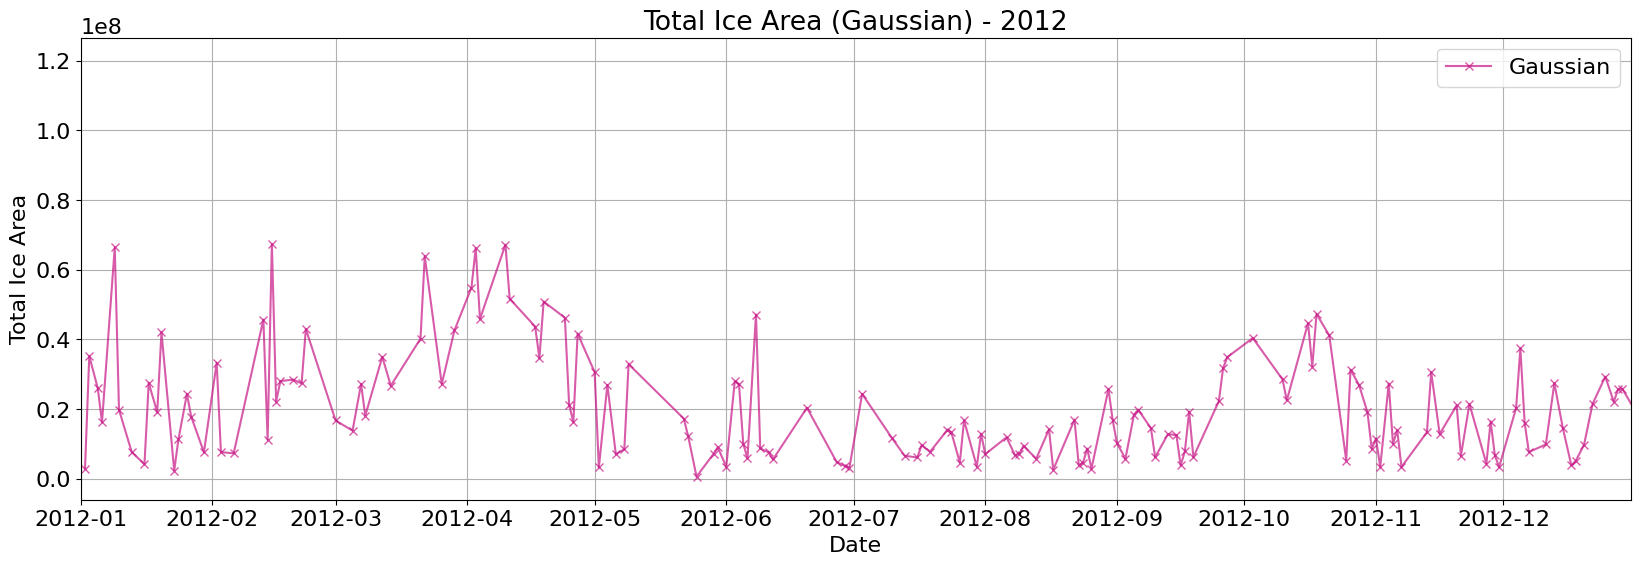

In [196]:
# Plot the results
plt.figure(figsize=(20, 6))
plt.plot(iara['date'], iara['area'], c='mediumvioletred', marker='x', alpha=0.7, label='Gaussian')
plt.xlabel('Date')
plt.ylabel('Total Ice Area')
start_date = datetime(2012, 1, 1)
end_date = datetime(2012, 12, 31) #(2015, 4, 30) 
plt.xlim(start_date, end_date)
# plt.ylim(0,1.3e6)
plt.title('Total Ice Area (Gaussian) - 2012')
plt.legend()
plt.grid()
# plt.savefig("C:/Users/jullian.williams/Desktop/plots2b.png", bbox_inches="tight", pad_inches=0.3, transparent=True)
plt.show()

C:\Users\jullian.williams\AppData\Local\Temp\ipykernel_10716\2493872439.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


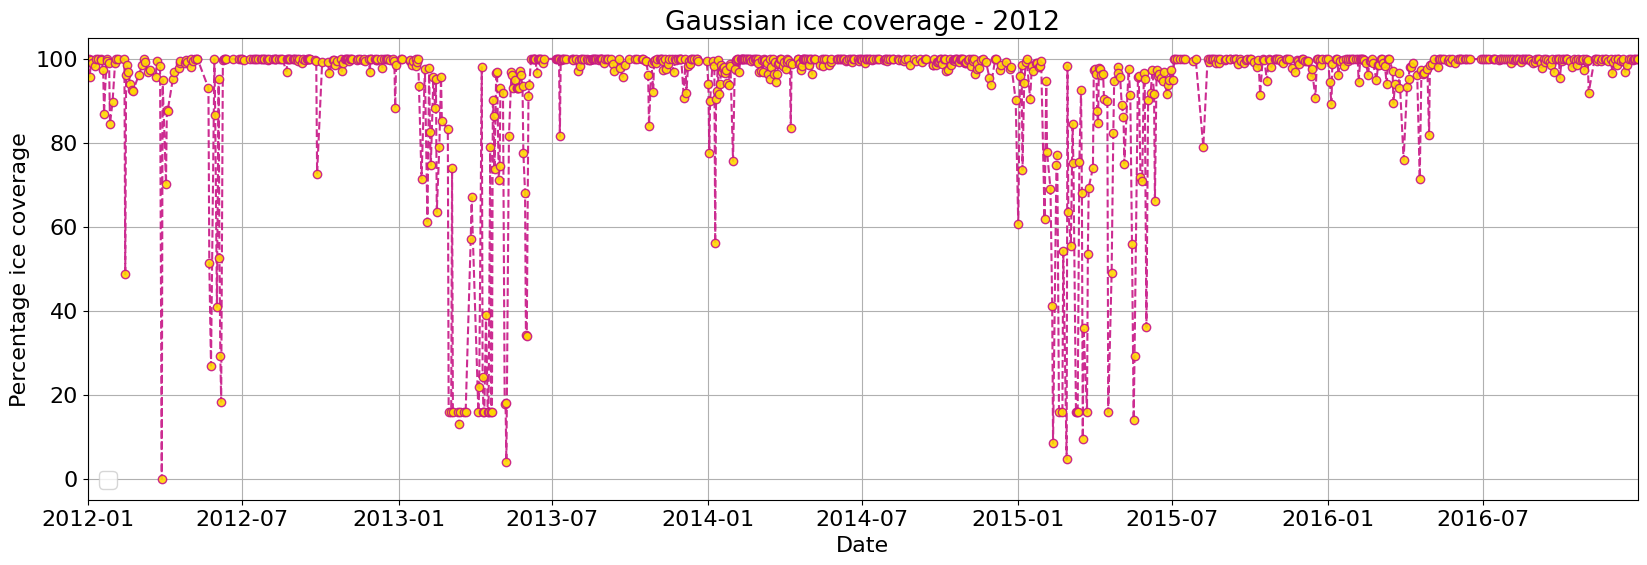

In [174]:
# Plot the results
plt.figure(figsize=(20, 6))
plt.plot(mx['date'], mx['perc'], c='mediumvioletred', linestyle='--', marker='o',markerfacecolor='gold', alpha=0.9)
plt.xlabel('Date')
plt.ylabel('Percentage ice coverage')
start_date = datetime(2012, 1, 1)
end_date = datetime(2016, 12, 31) #(2015, 4, 30) 
plt.xlim(start_date, end_date)
# plt.ylim(0,1.3e6)
plt.title('Gaussian ice coverage - 2012')
plt.legend()
plt.grid()
# plt.savefig("C:/Users/jullian.williams/Desktop/plots.png", bbox_inches="tight", pad_inches=0.3, transparent=True)
plt.show()

#### Linear regression

In [175]:
y = mx['area_y'].to_numpy()
stlist = mx['julian'].to_numpy()
x = [float(i) for i in stlist]
x = np.array(x)
print(x)

[  2.   3.   5.   6.   9.  10.  13.  16.  17.  19.  20.  23.  24.  26.
  27.  30.  33.  34.  37.  44.  45.  46.  47.  48.  51.  53.  54.  61.
  65.  67.  68.  72.  74.  81.  82.  86.  88.  89.  93.  94.  95. 101.
 102. 108. 109. 110. 115. 116. 117. 118. 122. 123. 125. 127. 129. 130.
 143. 144. 146. 150. 151. 153. 155. 156. 157. 158. 160. 161. 163. 164.
 172. 179. 181. 182. 185. 192. 195. 198. 199. 201. 205. 206. 208. 209.
 212. 213. 214. 219. 221. 222. 223. 226. 229. 230. 235. 236. 237. 238.
 239. 243. 244. 245. 247. 249. 250. 253. 254. 257. 259. 260. 261. 262.
 263. 269. 270. 271. 277. 284. 285. 290. 291. 292. 295. 299. 300. 302.
 304. 305. 306. 307. 309. 310. 311. 312. 318. 319. 321. 325. 326. 328.
 332. 333. 334. 335. 339. 340. 341. 342. 346. 348. 350. 352. 353. 355.
 357. 360. 362. 363. 364.   4.   5.  14.  15.  17.  18.  21.  22.  23.
  24.  25.  28.  32.  35.  37.  38.  39.  42.  44.  45.  46.  49.  51.
  52.  59.  60.  63.  64.  65.  71.  72.  73.  78.  80.  86.  87.  95.
  96. 

In [176]:
def calc_linreg_coef(x,y):
    if(np.size(x) !=np.size(y)):
        sys.exit("Length of x and y are not the same")

    #Number of observations
    n = np.size(x)

    sx = np.sum(x)
    sy = np.sum(y)
    
    sx2 = np.inner(x,x)
    sxy = np.inner(x,y)
    sy2 = np.inner(y,y)

    #Calculation of regression coefficients
    a1 = (n*sxy - sx*sy)/(n*sx2 - sx**2)
    a0 = (sy/n) - (a1*sx)/n

    r2 = ((n*sxy-sx*sy)/np.sqrt(n*sx2-sx**2)/np.sqrt(n*sy2-sy**2))**2;
          
    return (a0, a1, r2)
        

In [177]:
a0, a1, r2 = calc_linreg_coef(x,y)

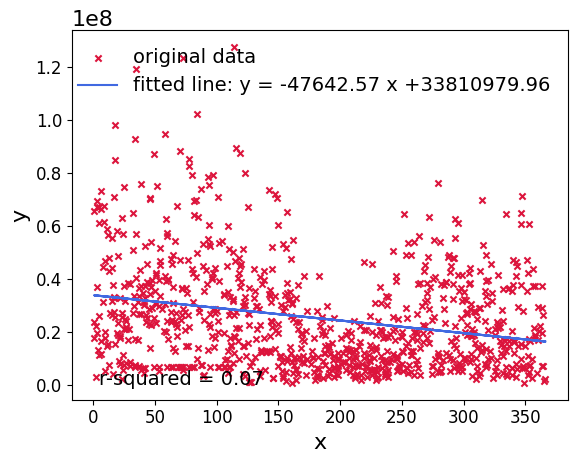

In [178]:
plt.scatter(x,y, c= 'crimson', marker='x', s=20, label = 'original data')
y_pred = a0 + a1*x
plt.plot(x,y_pred, color = 'royalblue', label = 'fitted line: y = %.2f x +%.2f'%(a1,a0)) 
plt.text(5,5,'r-squared = %.2f'%r2, fontsize = 14) 
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize =16)
plt.tick_params(axis='both', which='major', labelsize = 12)
plt.legend(loc='upper right', fontsize = 14, frameon=False)
plt.show()

#### Correlations and Fourier Analysis

In [179]:
mty = (rs2bin.groupby([rs2bin['date'].dt.month,'value']))['area'].mean().unstack()
mty

value            0.0            1.0
date                               
1      219941.285538  139284.636872
2      273325.688073  195695.280716
3      201246.739697  183581.926719
4      221314.984709  198551.636244
5      296807.805596  171234.156646
6      267341.609589  100627.431907
7       65378.787879   51492.204543
8      127592.592593   74619.010491
9      105567.729084  113278.566771
10      92396.825397  119266.934593
11     113044.041451  103459.775460
12     122330.188679  118625.666959

In [276]:
mty = (rst.groupby([rst['date'].dt.month,'value']))['area'].mean().unstack()
mty

value           0.0           1.0
date                             
1      2.655709e+06  3.078019e+07
2      7.041864e+06  3.164599e+07
3      5.433662e+06  2.933688e+07
4      3.965479e+06  3.018481e+07
5      3.664227e+06  2.226285e+07
6      4.108618e+06  1.625564e+07
7      1.797917e+05  1.215996e+07
8      4.593333e+05  1.403633e+07
9      5.888333e+05  2.265736e+07
10     5.706863e+05  2.524432e+07
11     5.194643e+05  2.049184e+07
12     7.203889e+05  2.190562e+07

In [180]:
icemty = (rs2bin.groupby([rs2bin['date'].dt.month,'value']))['area'].mean().unstack()
icemty

value            0.0            1.0
date                               
1      219941.285538  139284.636872
2      273325.688073  195695.280716
3      201246.739697  183581.926719
4      221314.984709  198551.636244
5      296807.805596  171234.156646
6      267341.609589  100627.431907
7       65378.787879   51492.204543
8      127592.592593   74619.010491
9      105567.729084  113278.566771
10      92396.825397  119266.934593
11     113044.041451  103459.775460
12     122330.188679  118625.666959

In [277]:
icemty = (rst.groupby([rst['date'].dt.month,'value']))['area'].mean().unstack()
icemty

value           0.0           1.0
date                             
1      2.655709e+06  3.078019e+07
2      7.041864e+06  3.164599e+07
3      5.433662e+06  2.933688e+07
4      3.965479e+06  3.018481e+07
5      3.664227e+06  2.226285e+07
6      4.108618e+06  1.625564e+07
7      1.797917e+05  1.215996e+07
8      4.593333e+05  1.403633e+07
9      5.888333e+05  2.265736e+07
10     5.706863e+05  2.524432e+07
11     5.194643e+05  2.049184e+07
12     7.203889e+05  2.190562e+07

In [181]:
iceyrl = (rs2bin.groupby([rs2bin['date'].dt.year,'value']))['area'].mean().unstack()
iceyrl

value            0.0            1.0
date                               
2012   201903.898459   95572.186548
2013   253799.070248  119029.432144
2014   130458.374628  119179.310345
2015   246090.965927  186166.936955
2016   140097.744361  133349.116462

In [278]:
iceyrl = (rst.groupby([rst['date'].dt.year,'value']))['area'].mean().unstack()
iceyrl

value           0.0           1.0
date                             
2012   2.319792e+06  2.006472e+07
2013   3.639667e+06  1.993052e+07
2014   9.823321e+05  2.486778e+07
2015   5.919135e+06  2.782914e+07
2016   9.506633e+05  2.388237e+07

In [279]:
cormty = mty.corr()
corimty = icemty.corr()
coriyrl = iceyrl.corr()
cormty

value       0.0       1.0
value                    
0.0    1.000000  0.617313
1.0    0.617313  1.000000

In [280]:
corimty

value       0.0       1.0
value                    
0.0    1.000000  0.617313
1.0    0.617313  1.000000

In [281]:
coriyrl

value       0.0       1.0
value                    
0.0    1.000000  0.318753
1.0    0.318753  1.000000

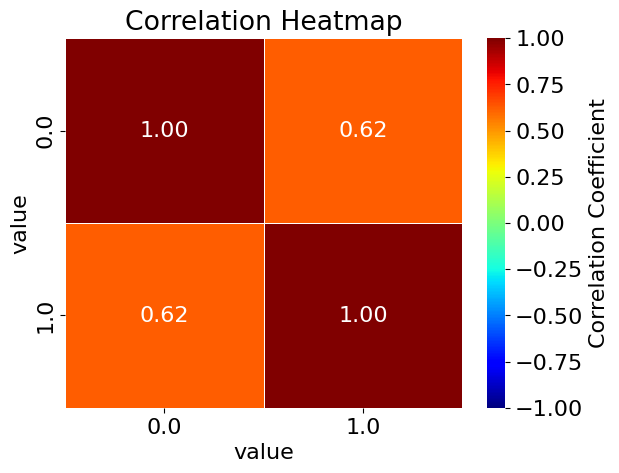

In [282]:
sns.heatmap(
    cormty, 
    annot=True, 
    fmt=".2f",  # Format for annotations:- decimal places
    cmap="jet",  # Custom color map
    linewidths=0.5,  # separation of blocks
    vmin = -1,
    vmax = 1,
    cbar_kws={'label': 'Correlation Coefficient'}  # Customize color bar
)
plt.title('Correlation Heatmap')
plt.show()

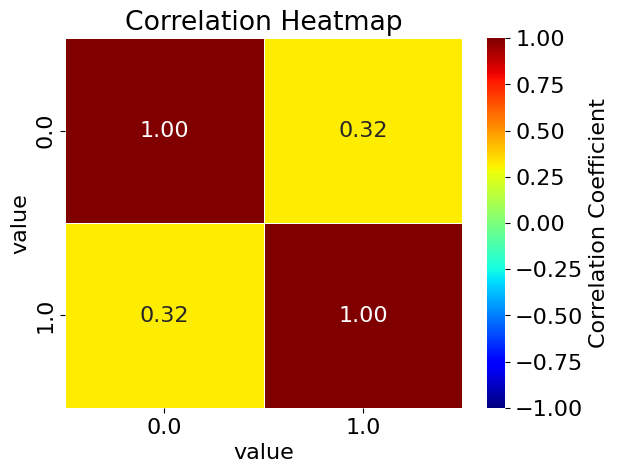

In [283]:
sns.heatmap(
    coriyrl, 
    annot=True, 
    fmt=".2f",  # Format for annotations:- decimal places
    cmap="jet",  # Custom color map
    linewidths=0.5,  # separation of blocks
    vmin = -1,
    vmax = 1,
    cbar_kws={'label': 'Correlation Coefficient'}  # Customize color bar
)
plt.title('Correlation Heatmap')
plt.show()

In [256]:
vt = (rs2bin.groupby([rs2bin['date'].dt.year,'value']))['area'].mean().unstack()

In [257]:
vt1 = vt[1]
vt1 = vt1.to_numpy()
vt1

array([ 95572.18654849, 119029.43214439, 119179.31034483, 186166.9369552 ,
       133349.11646204])

In [258]:
vtft = fft(vt1)
vtft

array([653296.98245495    -0.j        , -73468.85615078+52993.16808924j,
       -14249.16870547-55292.11953954j, -14249.16870547+55292.11953954j,
       -73468.85615078-52993.16808924j])

In [259]:
N = len(vtft)
n=np.arange(N)
sr=1/31556952 #placed in terms of seconds in year instead of # of years since hertz is in seconds but the plot looks virtually no different when run all the way through to the reconstruction plot
T = N/sr
freq = n/T

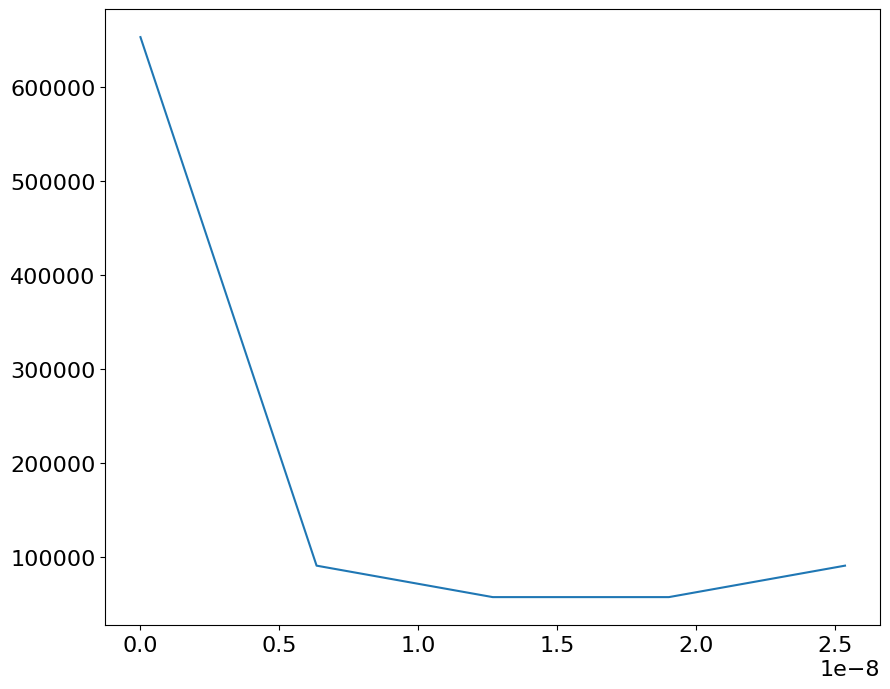

In [260]:
plt.figure(figsize=(10,8))
plt.plot(freq,np.abs(vtft)) #plot power spectrum as well

Text(0, 0.5, 'FFT amplitude')

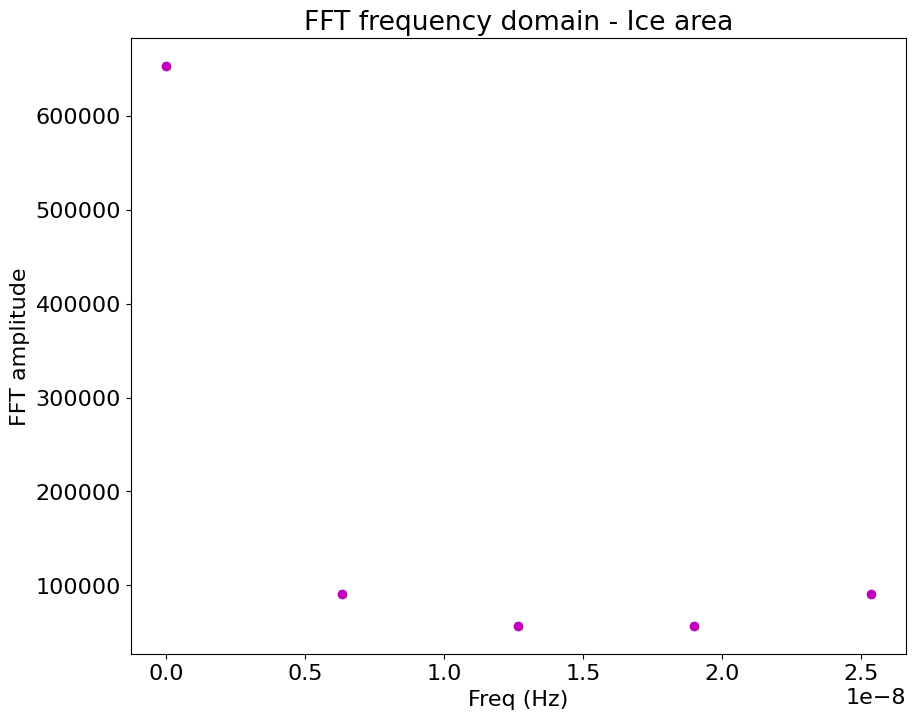

In [261]:
plt.figure(figsize=(10,8))
plt.plot(freq,np.abs(vtft),'mo') #plot power spectrum as well
plt.xlabel('Freq (Hz)')
plt.title('FFT frequency domain - Ice area')
plt.ylabel('FFT amplitude')

C:\Users\jullian.williams\AppData\Local\Temp\ipykernel_10716\511579271.py:11: RuntimeWarning: divide by zero encountered in divide
  np.allclose(peak_freq, 1./freq)


[]

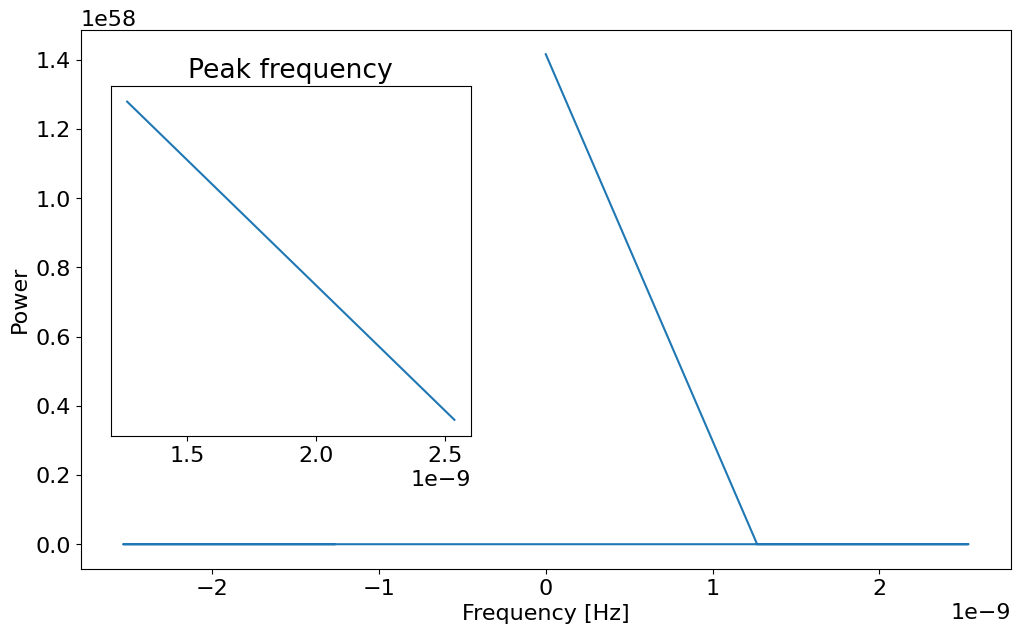

In [262]:
power = np.abs(vtft)**10
sample_freq = fftpack.fftfreq(vt1.size, d=T)
plt.figure(figsize=(12,7))
plt.plot(sample_freq, power)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')

pos_mask = np.where(sample_freq > 0)
freqs = sample_freq[pos_mask]
peak_freq = freqs[power[pos_mask].argmax()]
np.allclose(peak_freq, 1./freq)
axes = plt.axes([0.15, 0.3, 0.3, 0.5])
plt.title('Peak frequency')
plt.plot(freqs[:2], power[:2])
plt.setp(axes, yticks=[])

C:\Users\jullian.williams\.conda\envs\geospatial\lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\jullian.williams\.conda\envs\geospatial\lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


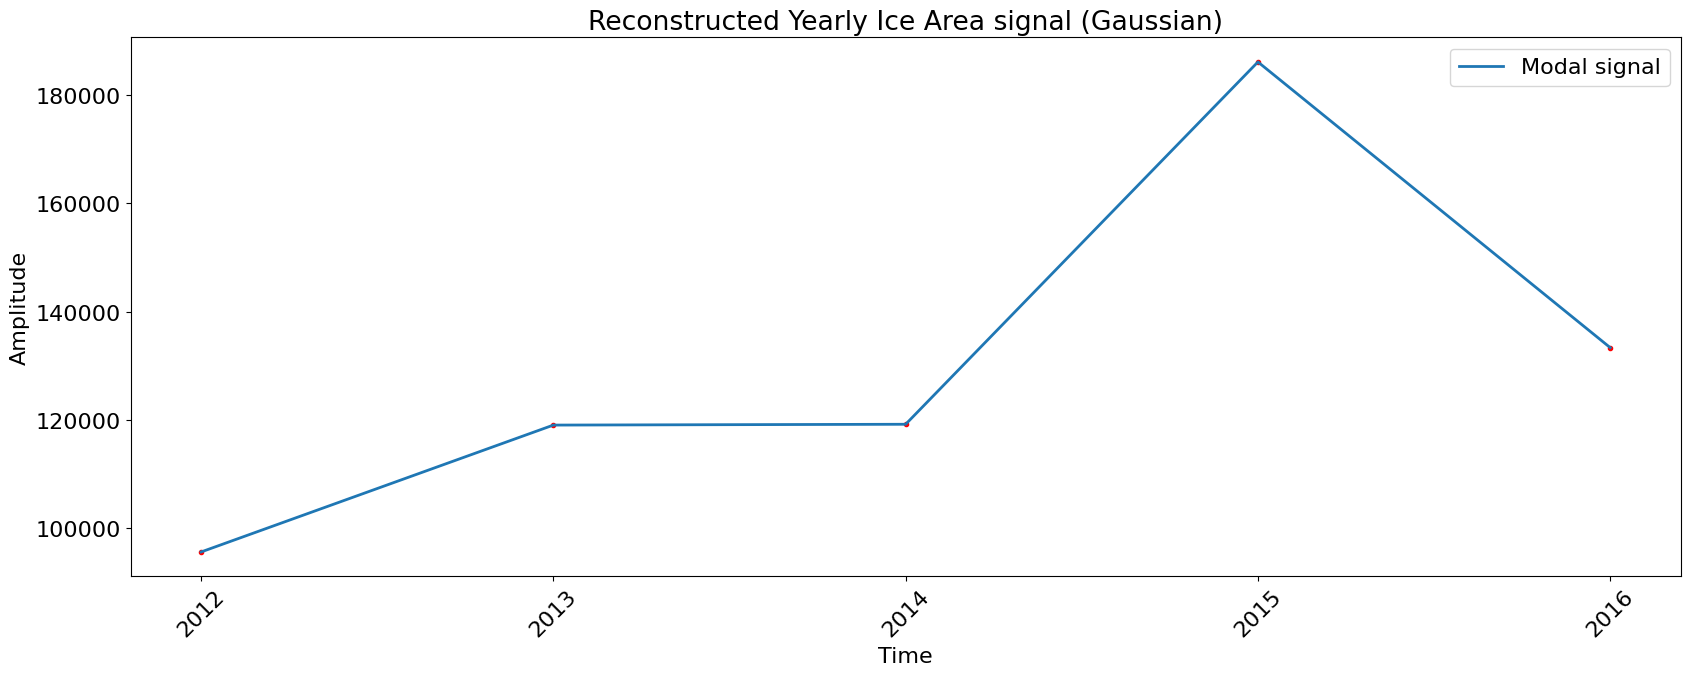

In [263]:
high_freq_fft = vtft.copy()
high_freq_fft[20::] = 0
filtered_sig = fftpack.ifft(high_freq_fft)

plt.figure(figsize=(20,7))
plt.plot(n, vt1, 'r.')
plt.plot(n, filtered_sig, linewidth=2, label= 'Modal signal')
plt.xticks(ticks=[0.0, 1.0, 2.0, 3.0, 4.0], labels=['2012', '2013', '2014', '2015', '2016'], rotation=45)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Reconstructed Yearly Ice Area signal (Gaussian)')
plt.legend(loc='best')

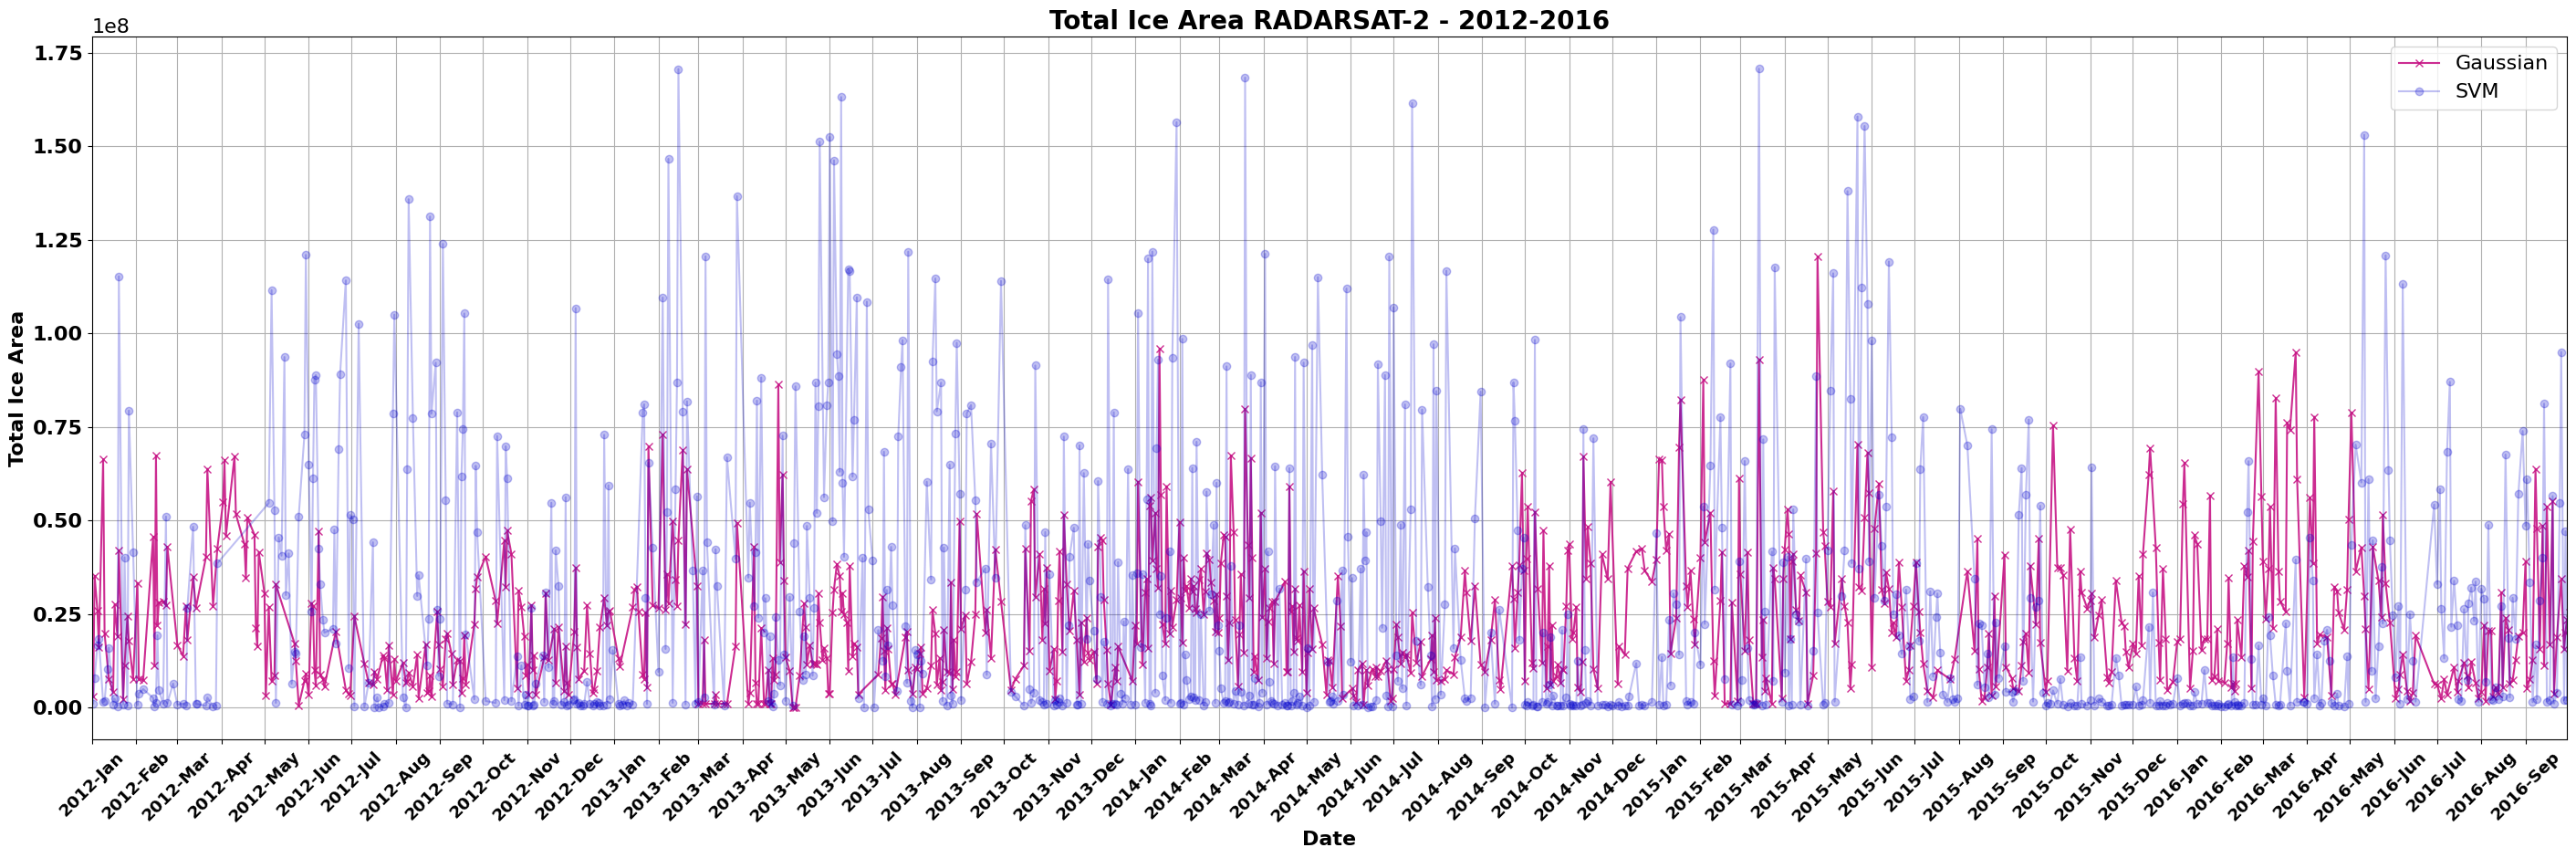

In [289]:
# Plot the results
plt.figure(figsize=(35, 10))
plt.rcParams.update({'font.size': 16})
plt.plot(iara['date'], iara['area'], c='mediumvioletred', marker='x', alpha=0.9, label='Gaussian')
plt.plot(iceara['date'], iceara['area'], c='mediumblue', marker='o', alpha=0.25, label='SVM')
plt.xlabel('Date', fontweight='bold')
plt.ylabel('Total Ice Area',fontweight='bold')
start_date = datetime(2012, 1, 1)
end_date = datetime(2016, 9, 30)
plt.xlim(start_date, end_date)
# plt.ylim(0,1.8e8)
dtFmt = mdates.DateFormatter('%Y-%b') # define the formatting
plt.gca().xaxis.set_major_formatter(dtFmt) 
# show every 12th tick on x axes
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45, fontweight='bold',  fontsize='small')
plt.yticks(fontweight='bold')
plt.title('Total Ice Area RADARSAT-2 - 2012-2016', fontweight='bold', fontsize=20)
plt.legend()
plt.grid()
# plt.savefig("C:/Users/jullian.williams/Desktop/plots.png", bbox_inches="tight", pad_inches=0.3, transparent=True)
plt.show()

# Principal Components

### Comparing ice area from SVM and Gaussian methods for 2012 - 2016

In [121]:
iara.head(2)

date  value        area  julian
0 2012-01-02    1.0   2950000.0     2.0
2 2012-01-03    1.0  35235000.0     3.0

In [122]:
iara.info

<bound method DataFrame.info of            date  value        area  julian
0    2012-01-02    1.0   2950000.0     2.0
2    2012-01-03    1.0  35235000.0     3.0
4    2012-01-05    1.0  26002500.0     5.0
6    2012-01-06    1.0  16237500.0     6.0
8    2012-01-09    1.0  66387500.0     9.0
...         ...    ...         ...     ...
1253 2016-02-23    1.0  44572500.0    54.0
1255 2016-02-27    1.0  89947500.0    58.0
1257 2016-02-29    1.0  56337500.0    60.0
1259 2016-03-01    1.0  39085000.0    61.0
1261 2016-03-03    1.0  23830000.0    63.0

[743 rows x 4 columns]>

In [130]:
iceara.head(2)

date  value       area
1 2012-01-02    1.0  1140000.0
3 2012-01-03    1.0  7987500.0

In [175]:
iceara.info

<bound method DataFrame.info of            date  value        area
1    2012-01-02    1.0   1140000.0
3    2012-01-03    1.0   7987500.0
5    2012-01-05    1.0  16722500.0
7    2012-01-06    1.0  18317500.0
9    2012-01-09    1.0   1452500.0
...         ...    ...         ...
1235 2016-02-19    1.0  52227500.0
1237 2016-02-20    1.0  65177500.0
1239 2016-02-22    1.0  12925000.0
1241 2016-02-23    1.0  35187500.0
1243 2016-03-01    1.0  71212500.0

[615 rows x 3 columns]>

In [290]:
svmgs = pd.merge(iceara,iara, on='date',how='outer').fillna(0)
svmgs['julian'] = svmgs['date'].dt.strftime('%j')
print(svmgs)

           date  value_x      area_x  value_y      area_y julian
0    2012-01-02      1.0   1140000.0      1.0   2950000.0    002
1    2012-01-03      1.0   7987500.0      1.0  35235000.0    003
2    2012-01-05      1.0  16722500.0      1.0  26002500.0    005
3    2012-01-06      1.0  18317500.0      1.0  16237500.0    006
4    2012-01-09      1.0   1452500.0      1.0  66387500.0    009
...         ...      ...         ...      ...         ...    ...
1004 2016-12-25      0.0         0.0      1.0  16882500.0    360
1005 2016-12-26      0.0         0.0      1.0  20477500.0    361
1006 2016-12-28      0.0         0.0      1.0  19557500.0    363
1007 2016-12-30      0.0         0.0      1.0   1387500.0    365
1008 2016-12-31      0.0         0.0      1.0   2400000.0    366

[1009 rows x 6 columns]


In [291]:
svmgs = svmgs.drop(['date','value_x', 'value_y'], axis=1)
print(svmgs)

          area_x      area_y julian
0      1140000.0   2950000.0    002
1      7987500.0  35235000.0    003
2     16722500.0  26002500.0    005
3     18317500.0  16237500.0    006
4      1452500.0  66387500.0    009
...          ...         ...    ...
1004         0.0  16882500.0    360
1005         0.0  20477500.0    361
1006         0.0  19557500.0    363
1007         0.0   1387500.0    365
1008         0.0   2400000.0    366

[1009 rows x 3 columns]


In [292]:
pca= PCA(3)
rpca = svmgs.iloc[:, 0:3]
pca.fit(rpca)

PCA(n_components=3)

In [293]:
rpca.head(2)

area_x      area_y julian
0  1140000.0   2950000.0    002
1  7987500.0  35235000.0    003

In [294]:
print(pca.components_)
print(pca.explained_variance_)

[[ 9.98154443e-01  6.07264954e-02 -3.72228001e-07]
 [-6.07264954e-02  9.98154443e-01 -1.00370155e-06]
 [ 3.10589756e-07  1.02445326e-06  1.00000000e+00]]
[1.28004367e+15 3.47772624e+14 1.08083240e+04]


In [295]:
t = pca.transform(rpca)
print(t)

[[-2.62541624e+07 -1.59714264e+07 -2.04802089e+02]
 [-1.74587450e+07  1.58381651e+07 -1.68600852e+02]
 [-9.30052327e+06  6.09225825e+06 -1.73346115e+02]
 ...
 [-2.63835432e+07  6.74651684e+05  1.72857446e+02]
 [-2.74869436e+07 -1.74618146e+07  1.56243131e+02]
 [-2.74254581e+07 -1.64511832e+07  1.58280390e+02]]


In [296]:
scaler = StandardScaler()
scaler.fit(rpca)

StandardScaler()

In [297]:
scaled_data = scaler.transform(rpca)

In [298]:
pca = PCA(n_components=3)
pca.fit(scaled_data)

PCA(n_components=3)

In [299]:
PCA(n_components=3)

PCA(n_components=3)

In [300]:
r_pca = pca.transform(scaled_data)
r_pca

array([[-0.17475222, -0.51545455, -1.97707885],
       [-1.2996579 , -1.14978464, -0.8195789 ],
       [-1.10687394, -0.70601283, -1.08230112],
       ...,
       [ 1.47586585, -0.26572305,  1.10639038],
       [ 2.07296019,  0.18915756,  0.49167176],
       [ 2.0463694 ,  0.16593278,  0.5336677 ]])

In [301]:
r_pca[0:,0],r_pca[:,1]

(array([-0.17475222, -1.2996579 , -1.10687394, ...,  1.47586585,
         2.07296019,  2.0463694 ]),
 array([-0.51545455, -1.14978464, -0.70601283, ..., -0.26572305,
         0.18915756,  0.16593278]))

Text(0.5, 1.0, 'Principal components - 2012-2016')

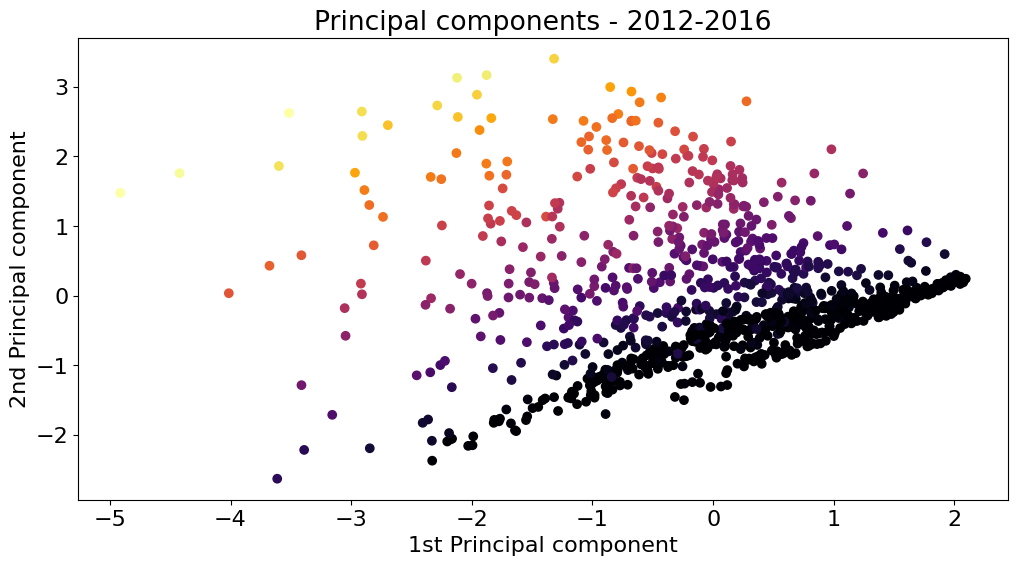

In [302]:
figx = plt.figure(figsize=(12,6))
plt.scatter(r_pca[:,0],r_pca[:,1], c = svmgs['area_x'], cmap='inferno')
plt.xlabel('1st Principal component')
plt.ylabel('2nd Principal component')
plt.title('Principal components - 2012-2016')

<Axes: >

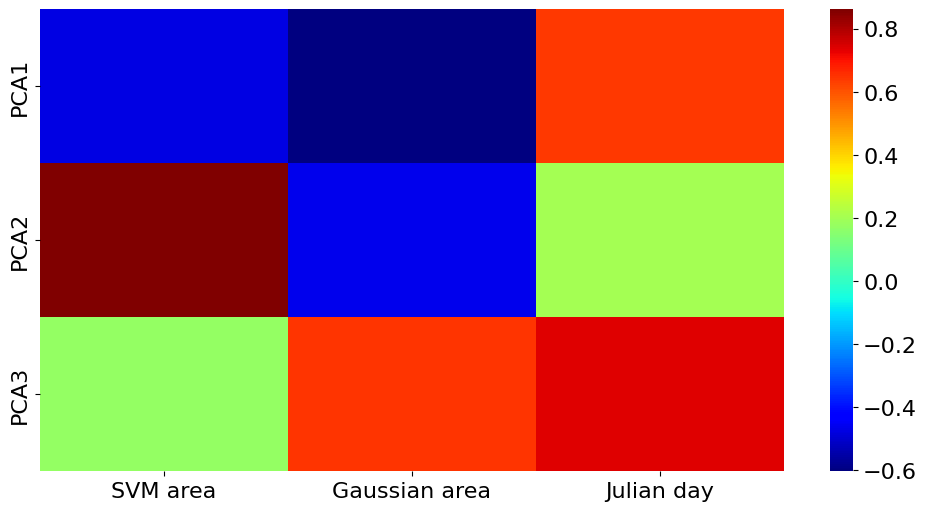

In [303]:
figx = plt.figure(figsize=(12,6))
map = pd.DataFrame(pca.components_, columns=['SVM area','Gaussian area','Julian day'])
sns.heatmap(map,cmap='jet',yticklabels=(['PCA1','PCA2','PCA3']))

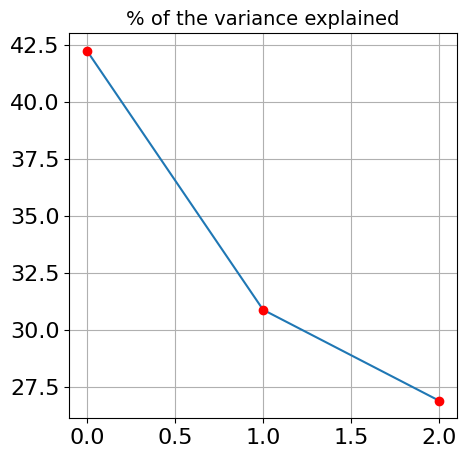

In [304]:
f, ax = plt.subplots(figsize=(5,5))
ax.plot(pca.explained_variance_ratio_[0:100]*100)
ax.plot(pca.explained_variance_ratio_[0:100]*100,'ro')
ax.set_title("% of the variance explained", fontsize=14)
ax.grid()

# Hypothesis testing

## Testing for normal data

### SVM method

In [75]:
gauss_data = rs2

In [76]:
gauss_data.head(4)

value                                           geometry       date  \
0    0.0  POLYGON ((500275 8558875, 500275 8558825, 5003... 2012-02-03   
1    1.0  POLYGON ((500825 8558275, 500825 8558225, 5007... 2012-02-03   
2    1.0  POLYGON ((501175 8558075, 501175 8558025, 5010... 2012-02-03   
3    0.0  POLYGON ((499575 8557625, 499575 8557575, 4996... 2012-02-03   

      area  perimeter                        centroid      longitude  \
0   2500.0      200.0          POINT (500300 8558850)  500300.000000   
1  17500.0      700.0  POINT (500871.429 8558207.143)  500871.428571   
2  70000.0     1700.0  POINT (501280.357 8557910.714)  501280.357143   
3   2500.0      200.0          POINT (499600 8557600)  499600.000000   

       latitude  julian  
0  8.558850e+06    34.0  
1  8.558207e+06    34.0  
2  8.557911e+06    34.0  
3  8.557600e+06    34.0

In [77]:
#When gauss_data = rs2
gauss_data['julian'] = gauss_data['date'].dt.strftime('%j')
gauss_data['julian'] = gauss_data['julian'].to_numpy()
gauss_data['julian'] = [float(i) for i in gauss_data['julian']]
gauss_data['julian'] = np.array(gauss_data['julian'])
print(gauss_data['julian'])

0          34.0
1          34.0
2          34.0
3          34.0
4          34.0
           ... 
1812784    61.0
1812785    61.0
1812787    61.0
1812789    61.0
1812790    61.0
Name: julian, Length: 1811193, dtype: float64


In [78]:
gauss_data = gauss_data.drop(['value','perimeter','longitude','latitude','geometry','centroid','date','julian'], axis=1)
print(gauss_data)

            area
0         2500.0
1        17500.0
2        70000.0
3         2500.0
4         2500.0
...          ...
1812784   2500.0
1812785   5000.0
1812787  10000.0
1812789   2500.0
1812790  15000.0

[1811193 rows x 1 columns]


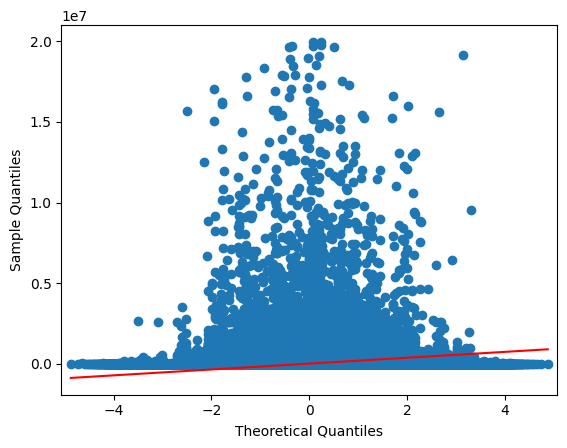

In [79]:
qqplot_data=qqplot(gauss_data, line='s').gca().lines #data is not normal. at all. test it another way. #line is: "r", "q", "45" or "s"

In [80]:
gd = gauss_data['area']
gd

0           2500.0
1          17500.0
2          70000.0
3           2500.0
4           2500.0
            ...   
1812784     2500.0
1812785     5000.0
1812787    10000.0
1812789     2500.0
1812790    15000.0
Name: area, Length: 1811193, dtype: float64

In [81]:
np.mean(gd),np.std(gd),np.min(gd),np.max(gd)

(17152.78272387316, 182154.19766844567, 2500.0, 19960000.0)

In [82]:
stat,p = normaltest(gd)

In [83]:
print(f"Statistic: {stat}")
print(f"P-value: {p}")
if p < 0.05:
    print("The data does not follow a normal distribution (reject null hypothesis).")
else:
    print("The data follows a normal distribution (fail to reject null hypothesis).")

Statistic: 5818618.854469605
P-value: 0.0
The data does not follow a normal distribution (reject null hypothesis).


### Gaussian method

In [111]:
gauss_data = rs2bin

In [86]:
gauss_data = iara

In [107]:
gauss_data.head(4)

value                                           geometry       date  \
0    1.0  POLYGON ((499625 8557925, 499625 8557875, 4995... 2012-01-02   
1    1.0  POLYGON ((522875 8557375, 522875 8557325, 5228... 2012-01-02   
2    1.0  POLYGON ((498975 8556975, 498975 8556825, 4990... 2012-01-02   
3    1.0  POLYGON ((523075 8556725, 523075 8556675, 5231... 2012-01-02   

      area  perimeter                        centroid      longitude  \
0  37500.0      900.0  POINT (499626.667 8557783.333)  499626.666667   
1  15000.0      700.0          POINT (522850 8557275)  522850.000000   
2  12500.0      500.0          POINT (499020 8556890)  499020.000000   
3   2500.0      200.0          POINT (523100 8556700)  523100.000000   

       latitude  julian  
0  8.557783e+06     2.0  
1  8.557275e+06     2.0  
2  8.556890e+06     2.0  
3  8.556700e+06     2.0

In [112]:
#When gauss_data = rs2bin
gauss_data['julian'] = gauss_data['date'].dt.strftime('%j')
gauss_data['julian'] = gauss_data['julian'].to_numpy()
gauss_data['julian'] = [float(i) for i in gauss_data['julian']]
gauss_data['julian'] = np.array(gauss_data['julian'])
print(gauss_data['julian'])

0          2.0
1          2.0
2          2.0
3          2.0
4          2.0
          ... 
146201    63.0
146202    63.0
146203    63.0
146205    63.0
146206    63.0
Name: julian, Length: 145022, dtype: float64


In [ ]:
#When gauss_data = iara
gauss_data['julian'] = gauss_data['date'].dt.strftime('%j')
gauss_data['julian'] = gauss_data['julian'].to_numpy()
gauss_data['julian'] = [float(i) for i in gauss_data['julian']]
gauss_data['julian'] = np.array(gauss_data['julian'])
print(gauss_data['julian'])

In [113]:
#When gauss_data = rs2bin
gauss_data = gauss_data.drop(['value','perimeter','longitude','latitude','geometry','centroid','date','julian'], axis=1)
print(gauss_data)

             area
0         37500.0
1         15000.0
2         12500.0
3          2500.0
4          2500.0
...           ...
146201    40000.0
146202  2700000.0
146203    30000.0
146205     5000.0
146206    40000.0

[145022 rows x 1 columns]


In [89]:
#When gauss_data = iara
gauss_data = gauss_data.drop(['value','date'], axis=1)
print(gauss_data)

            area  julian
0      2950000.0     2.0
2     35235000.0     3.0
4     26002500.0     5.0
6     16237500.0     6.0
8     66387500.0     9.0
...          ...     ...
1253  44572500.0    54.0
1255  89947500.0    58.0
1257  56337500.0    60.0
1259  39085000.0    61.0
1261  23830000.0    63.0

[743 rows x 2 columns]


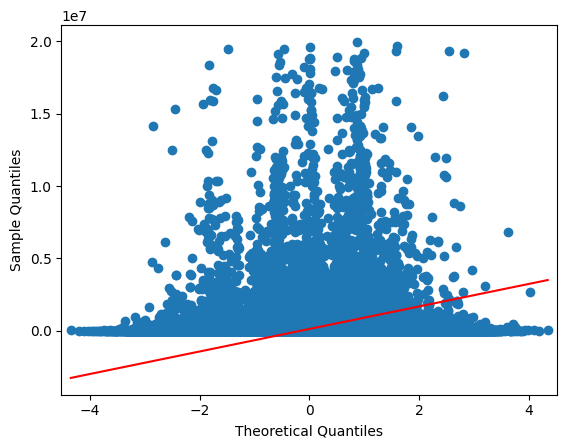

In [119]:
qqplot_data=qqplot(gauss_data, line='s').gca().lines #data is not normal. at all. test it another way. #line is: "r", "q", "45" or "s"

In [73]:
gd = gauss_data['area']
gd

0           37500.0
1           15000.0
2           12500.0
3            2500.0
4            2500.0
            ...    
146201      40000.0
146202    2700000.0
146203      30000.0
146205       5000.0
146206      40000.0
Name: area, Length: 145022, dtype: float64

In [120]:
np.mean(gd),np.std(gd),np.min(gd),np.max(gd)

(131247.638289363, 777085.8503269099, 2500.0, 19947500.0)

In [74]:
stat,p = normaltest(gd)

In [81]:
print(f"Statistic: {stat}")
print(f"P-value: {p}")
if p < 0.05:
    print("The data does not follow a normal distribution (reject null hypothesis).")
else:
    print("The data follows a normal distribution (fail to reject null hypothesis).")

Statistic: 263482.6010931189
P-value: 0.0
The data does not follow a normal distribution (reject null hypothesis).
